In [1]:
"""
@author Anthony Martin
@email am@cadenzai.net

Fixed Implementation of RDF vs I-Con Benchmark for Notebooks
===========================================================

This implementation resolves the tensor transformation issue and provides
a cleaner comparison between the frameworks.
"""

import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image


# Data utilities
def get_datasets(dataset_name):
    """
    Load standard datasets for benchmarking.
    """
    # Base transform for test set
    base_transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Create augmentation transform for contrastive learning
    augment_transform = transforms.Compose([
        transforms.Resize(32),
        transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # For STL-10, we need to use slightly different transforms due to larger images
    stl10_base_transform = transforms.Compose([
        transforms.Resize(64),  # Resize to 64x64 instead of 32x32
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    stl10_augment_transform = transforms.Compose([
        transforms.Resize(64),
        transforms.RandomResizedCrop(64, scale=(0.2, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    if dataset_name == "cifar10":
        train_dataset = datasets.CIFAR10(
            root="./data", train=True, download=True, transform=None
        )
        test_dataset = datasets.CIFAR10(
            root="./data", train=False, download=True, transform=base_transform
        )
        return train_dataset, test_dataset, augment_transform

    elif dataset_name == "cifar100":
        train_dataset = datasets.CIFAR100(
            root="./data", train=True, download=True, transform=None
        )
        test_dataset = datasets.CIFAR100(
            root="./data", train=False, download=True, transform=base_transform
        )
        return train_dataset, test_dataset, augment_transform

    elif dataset_name == "stl10":
        train_dataset = datasets.STL10(
            root="./data", split="train", download=True, transform=None
        )
        test_dataset = datasets.STL10(
            root="./data", split="test", download=True, transform=stl10_base_transform
        )
        return train_dataset, test_dataset, stl10_augment_transform

    else:
        raise ValueError(f"Dataset {dataset_name} not supported")


# Configuration
class Config:
    def __init__(self, dataset_name="cifar10"):
        # General settings
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Adjust batch size based on dataset (STL-10 has larger images)
        if dataset_name == "stl10":
            self.batch_size = 32  # Smaller batch for larger images
        else:
            self.batch_size = 64

        self.num_epochs = 10
        self.lr = 0.001
        self.weight_decay = 1e-5
        self.embedding_dim = 64
        self.temperature = 0.5

        # Framework-specific settings
        # RDF settings
        self.rdf_recursion_depth = 3
        self.rdf_coupling_strength = 0.5

        # I-Con settings
        self.icon_p_distribution = "gaussian"
        self.icon_q_distribution = "gaussian"
        self.icon_debias_alpha = 0.2

# Modified contrastive dataset that correctly handles transformations
class ContrastiveDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.dataset[idx]

        # Convert tensor back to PIL Image if needed
        if isinstance(img, torch.Tensor):
            # Convert to PIL Image for transformation
            img = transforms.ToPILImage()(img)

        # Apply two different augmentations
        view1 = self.transform(img)
        view2 = self.transform(img)
        return view1, view2, label

    def __len__(self):
        return len(self.dataset)


# Neural network architectures
class EncoderNetwork(nn.Module):
    def __init__(self, model_name="resnet18", embedding_dim=128):
        super(EncoderNetwork, self).__init__()

        # Use a smaller model for notebooks
        self.backbone = models.resnet18(weights=None)  # No pre-training for fair comparison
        self.feature_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        # Projection head
        self.projection = nn.Sequential(
            nn.Linear(self.feature_dim, self.feature_dim),
            nn.ReLU(),
            nn.Linear(self.feature_dim, embedding_dim)
        )

    def forward(self, x):
        features = self.backbone(x)
        embeddings = self.projection(features)
        # Normalize embeddings to unit sphere
        embeddings = F.normalize(embeddings, p=2, dim=1)
        return embeddings

# Framework implementations
class RDF:
    """
    Implementation of the Recursive Divergence Fields framework.
    """
    def __init__(self, config):
        self.config = config
        self.recursion_depth = config.rdf_recursion_depth
        self.coupling_strength = config.rdf_coupling_strength
        self.device = config.device
        self.temperature = config.temperature

    def compute_loss(self, embeddings_1, embeddings_2):
        """
        Compute the RDF loss over recursively defined distributions.
        """
        batch_size = embeddings_1.shape[0]

        # Initial distribution (p^(0))
        p_0 = torch.zeros(batch_size, batch_size).to(self.device)
        # Set diagonal to 1 (positive pairs)
        p_0.fill_diagonal_(1.0)

        # Initial distribution (q^(0))
        # Calculate pairwise similarities
        sim_matrix = torch.mm(embeddings_1, embeddings_2.t())
        # Apply temperature scaling
        sim_matrix = sim_matrix / self.temperature
        # Apply softmax to get probability distribution
        q_0 = F.softmax(sim_matrix, dim=1)

        # Recursively update distributions
        p_t = p_0
        q_t = q_0

        # Store losses at each iteration
        losses = []

        for t in range(1, self.recursion_depth + 1):
            # Update p^(t) based on q^(t-1)
            p_t = self._update_p(q_t, p_t)

            # Update q^(t) based on current embeddings
            q_t = self._update_q(embeddings_1, embeddings_2, t)

            # Compute KL divergence at current iteration
            loss_t = 0
            for i in range(batch_size):
                # Add small epsilon to prevent log(0)
                epsilon = 1e-8
                # Compute KL divergence: DKL(p^(t)(·|i) || q^(t)(·|i))
                loss_i = torch.sum(p_t[i] * torch.log((p_t[i] + epsilon) / (q_t[i] + epsilon)))
                loss_t += loss_i

            # Normalize by batch size
            loss_t = loss_t / batch_size
            losses.append(loss_t)

        # Final loss is the sum of losses at each iteration
        final_loss = sum(losses)
        return final_loss

    def _update_p(self, q_prev, p_prev):
        """
        Update target distribution p^(t) based on previous q^(t-1)
        """
        # Implement FP function: Linear interpolation between initial p and previous q
        p_new = (1 - self.coupling_strength) * p_prev + self.coupling_strength * q_prev
        return p_new

    def _update_q(self, embeddings_1, embeddings_2, t):
        """
        Update learned distribution q^(t) based on current embeddings
        """
        batch_size = embeddings_1.shape[0]

        # Calculate pairwise similarities
        sim_matrix = torch.mm(embeddings_1, embeddings_2.t())

        # Apply time-dependent temperature scaling
        temp_t = self.temperature * (1 - 0.1 * (t / self.recursion_depth))
        sim_matrix = sim_matrix / temp_t

        # Apply softmax to get probability distribution
        q_new = F.softmax(sim_matrix, dim=1)

        return q_new

class ICon:
    """
    Implementation of the I-Con framework.
    """
    def __init__(self, config):
        self.config = config
        self.device = config.device
        self.p_distribution = config.icon_p_distribution
        self.q_distribution = config.icon_q_distribution
        self.debias_alpha = config.icon_debias_alpha
        self.temperature = config.temperature

    def compute_loss(self, embeddings_1, embeddings_2):
        """
        Compute the I-Con loss between two distributions.
        """
        batch_size = embeddings_1.shape[0]

        # Compute the supervisory distribution p(j|i)
        p = self._compute_p_distribution(embeddings_1, embeddings_2)

        # Apply debiasing if enabled
        if self.debias_alpha > 0:
            # Mix with uniform distribution
            uniform = torch.ones(batch_size, batch_size).to(self.device) / batch_size
            p = (1 - self.debias_alpha) * p + self.debias_alpha * uniform

        # Compute the learned distribution q(j|i)
        q = self._compute_q_distribution(embeddings_1, embeddings_2)

        # Compute KL divergence: DKL(p(·|i) || q(·|i))
        loss = 0
        for i in range(batch_size):
            # Add small epsilon to prevent log(0)
            epsilon = 1e-8
            loss_i = torch.sum(p[i] * torch.log((p[i] + epsilon) / (q[i] + epsilon)))
            loss += loss_i

        # Normalize by batch size
        loss = loss / batch_size
        return loss

    def _compute_p_distribution(self, embeddings_1, embeddings_2):
        """
        Compute the supervisory distribution p(j|i).
        """
        batch_size = embeddings_1.shape[0]

        # For simplified notebook demo, use identity matrix (positive pairs only)
        p = torch.eye(batch_size).to(self.device)

        # Normalize
        p = p / (torch.sum(p, dim=1, keepdim=True) + 1e-8)
        return p

    def _compute_q_distribution(self, embeddings_1, embeddings_2):
        """
        Compute the learned distribution q(j|i).
        """
        batch_size = embeddings_1.shape[0]

        if self.q_distribution == "gaussian":
            # Compute pairwise similarities (equivalent to InfoNCE/SimCLR)
            sim_matrix = torch.mm(embeddings_1, embeddings_2.t())
            # Apply temperature scaling
            sim_matrix = sim_matrix / self.temperature
            # Apply softmax to get probability distribution
            q = F.softmax(sim_matrix, dim=1)

        elif self.q_distribution == "student_t":
            # Compute pairwise distances
            dist_matrix = torch.cdist(embeddings_1, embeddings_2, p=2)
            # Apply Student's t-distribution kernel
            df = 1.0  # Degrees of freedom
            sim_matrix = -torch.log(1.0 + dist_matrix**2 / df)
            # Apply temperature scaling
            sim_matrix = sim_matrix / self.temperature
            # Apply softmax to get probability distribution
            q = F.softmax(sim_matrix, dim=1)

        else:
            # Default to Gaussian
            sim_matrix = torch.mm(embeddings_1, embeddings_2.t())
            sim_matrix = sim_matrix / self.temperature
            q = F.softmax(sim_matrix, dim=1)

        return q

# Training and evaluation
class RepresentationLearner:
    def __init__(self, framework, config):
        self.framework = framework
        self.config = config
        self.device = config.device

        # Create model
        self.model = EncoderNetwork(embedding_dim=config.embedding_dim).to(self.device)

        # Create optimizer
        self.optimizer = optim.Adam(
            self.model.parameters(), lr=config.lr, weight_decay=config.weight_decay
        )

        # Metrics
        self.train_losses = []

    def train(self, train_loader, test_loader):
        """
        Train the model on the specified dataset.
        """
        print(f"Training with {self.framework.__class__.__name__} framework...")

        # Train for specified number of epochs
        for epoch in range(self.config.num_epochs):
            self.model.train()
            epoch_loss = 0.0
            batch_count = 0

            # Iterate over batches
            for i, (views1, views2, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{self.config.num_epochs}")):
                views1, views2 = views1.to(self.device), views2.to(self.device)

                # Zero gradients
                self.optimizer.zero_grad()

                # Forward pass
                embeddings1 = self.model(views1)
                embeddings2 = self.model(views2)

                # Compute loss
                loss = self.framework.compute_loss(embeddings1, embeddings2)

                # Backward pass and optimize
                loss.backward()
                self.optimizer.step()

                # Update epoch loss
                epoch_loss += loss.item()
                batch_count += 1

                # Limit training iterations for notebook demo
                if i >= 10:  # Process only 10 batches per epoch for demo
                    break

            # Log epoch loss
            avg_epoch_loss = epoch_loss / batch_count
            self.train_losses.append(avg_epoch_loss)
            print(f"Epoch {epoch+1}, Loss: {avg_epoch_loss:.4f}")

            # Evaluate model periodically
            if (epoch + 1) % 5 == 0 or epoch == self.config.num_epochs - 1:
                self.evaluate(test_loader)

        print("Training complete!")
        return self.model

    def evaluate(self, test_loader):
        """
        Evaluate the model on various metrics.
        """
        self.model.eval()

        # Extract features and labels
        all_features = []
        all_labels = []

        with torch.no_grad():
            for i, (images, labels) in enumerate(tqdm(test_loader, desc="Evaluating")):
                images = images.to(self.device)
                features = self.model(images)
                all_features.append(features.cpu().numpy())
                all_labels.append(labels.numpy())

                # Limit evaluation for notebook demo
                if i >= 10:  # Process only 10 batches for demo
                    break

        all_features = np.vstack(all_features)
        all_labels = np.concatenate(all_labels)

        # Compute metrics
        metrics = {}

        # 1. Linear evaluation
        X_train, X_test, y_train, y_test = train_test_split(
            all_features, all_labels, test_size=0.2, random_state=42
        )

        classifier = LogisticRegression(max_iter=1000, random_state=42)
        classifier.fit(X_train, y_train)
        acc = classifier.score(X_test, y_test)
        metrics["linear_eval_accuracy"] = acc

        # 2. Clustering quality
        # Apply k-means clustering
        from sklearn.cluster import KMeans
        n_clusters = len(np.unique(all_labels))
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(all_features)

        # Calculate clustering metrics
        nmi = normalized_mutual_info_score(all_labels, cluster_labels)
        ari = adjusted_rand_score(all_labels, cluster_labels)
        metrics["nmi"] = nmi
        metrics["ari"] = ari

        # 3. Neighborhood preservation
        # Compute k-NN in the embedding space
        k = 5
        knn = NearestNeighbors(n_neighbors=k+1)
        knn.fit(all_features)
        distances, indices = knn.kneighbors(all_features)

        # Check if neighbors have the same label
        same_label_count = 0
        total_neighbors = 0
        for i in range(len(all_features)):
            for j in range(1, k+1):  # Skip the point itself (j=0)
                if all_labels[i] == all_labels[indices[i, j]]:
                    same_label_count += 1
                total_neighbors += 1

        neighborhood_accuracy = same_label_count / total_neighbors
        metrics["neighborhood_accuracy"] = neighborhood_accuracy

        # Print metrics
        print(f"Evaluation Metrics:")
        print(f"  Linear Eval Accuracy: {metrics['linear_eval_accuracy']:.4f}")
        print(f"  NMI: {metrics['nmi']:.4f}")
        print(f"  ARI: {metrics['ari']:.4f}")
        print(f"  Neighborhood Accuracy: {metrics['neighborhood_accuracy']:.4f}")

        return metrics

def run_benchmark(dataset_name="cifar10", frameworks=["rdf", "icon"]):
    """
    Run the benchmark comparing RDF and I-Con on specified dataset.
    """
    results = {}

    print(f"=== Running benchmark on {dataset_name} ===")
    results[dataset_name] = {}

    # Load dataset
    train_dataset, test_dataset, augment_transform = get_datasets(dataset_name)

    # Create contrastive dataset
    contrastive_train_dataset = ContrastiveDataset(train_dataset, augment_transform)

    # Create data loaders
    config = Config()
    train_loader = DataLoader(
        contrastive_train_dataset, batch_size=config.batch_size,
        shuffle=True, num_workers=0  # Set to 0 to avoid multiprocessing issues
    )

    test_loader = DataLoader(
        test_dataset, batch_size=config.batch_size,
        shuffle=False, num_workers=0
    )

    # Run benchmark for each framework
    for framework_name in frameworks:
        print(f"--- Evaluating {framework_name} framework ---")
        results[dataset_name][framework_name] = {}

        # Create framework
        if framework_name == "rdf":
            framework = RDF(config)
        elif framework_name == "icon":
            framework = ICon(config)
        else:
            raise ValueError(f"Unknown framework: {framework_name}")

        # Train and evaluate
        start_time = time.time()
        learner = RepresentationLearner(framework, config)
        learner.train(train_loader, test_loader)
        end_time = time.time()

        # Record training time
        training_time = end_time - start_time
        results[dataset_name][framework_name]["training_time"] = training_time
        print(f"Training time: {training_time:.2f} seconds")

        # Evaluate final model
        metrics = learner.evaluate(test_loader)
        results[dataset_name][framework_name]["metrics"] = metrics

        # Record training loss
        results[dataset_name][framework_name]["train_losses"] = learner.train_losses

    return results

def plot_results(results):
    """
    Plot comparison of frameworks across metrics.
    """
    # Setup
    dataset_name = list(results.keys())[0]
    frameworks = list(results[dataset_name].keys())
    metrics = list(results[dataset_name][frameworks[0]]["metrics"].keys())

    # Create figure for metrics
    fig, axes = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 4))

    if len(metrics) == 1:
        axes = [axes]

    # Plot metrics
    for i, metric in enumerate(metrics):
        ax = axes[i]

        # Collect metric values for each framework
        values = [results[dataset_name][framework]["metrics"][metric] for framework in frameworks]

        # Create bar chart
        ax.bar(frameworks, values)
        ax.set_title(f"{dataset_name} - {metric}")
        ax.set_ylim(0, 1)
        ax.set_ylabel("Score")

        # Add value labels
        for k, v in enumerate(values):
            ax.text(k, v + 0.02, f"{v:.4f}", ha="center")

    # Adjust layout
    plt.tight_layout()
    plt.show()

    # Plot training loss curves
    plt.figure(figsize=(10, 5))

    # Plot loss curves for each framework
    for framework in frameworks:
        losses = results[dataset_name][framework]["train_losses"]
        plt.plot(range(1, len(losses) + 1), losses, label=framework)

    plt.title(f"{dataset_name} - Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
# results = run_benchmark("cifar10", ["rdf", "icon"])
# plot_results(results)

In [2]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# Configuration
datasets_to_test = ['cifar10', 'cifar100', 'stl10']
frameworks = ['rdf', 'icon']
num_seeds = 5
seeds = [42, 123, 456, 789, 101]

# Results storage
results = {dataset: {framework: [] for framework in frameworks}
           for dataset in datasets_to_test}

# Run experiments
for dataset_name in datasets_to_test:
    print(f"Running experiments on {dataset_name}")
    for framework in frameworks:
        print(f"  Testing {framework} framework")
        for seed in seeds:
            print(f"    Seed {seed}")
            torch.manual_seed(seed)
            np.random.seed(seed)

            # Create dataset
            train_dataset, test_dataset, augment_transform = get_datasets(dataset_name)
            contrastive_train_dataset = ContrastiveDataset(train_dataset, augment_transform)

            # Create data loaders
            config = Config(dataset_name)
            train_loader = DataLoader(
                contrastive_train_dataset, batch_size=config.batch_size,
                shuffle=True, num_workers=4
            )

            test_loader = DataLoader(
                test_dataset, batch_size=config.batch_size,
                shuffle=False, num_workers=4
            )

            # Create framework
            if framework == "rdf":
                framework_obj = RDF(config)
            else:
                framework_obj = ICon(config)

            # Train and evaluate
            learner = RepresentationLearner(framework_obj, config)
            learner.train(train_loader, test_loader)
            metrics = learner.evaluate(test_loader)

            # Record results
            results[dataset_name][framework].append({
                'seed': seed,
                'final_loss': learner.train_losses[-1],
                'linear_eval_accuracy': metrics['linear_eval_accuracy'],
                'nmi': metrics['nmi'],
                'ari': metrics['ari'],
                'neighborhood_accuracy': metrics['neighborhood_accuracy']
            })

# Statistical analysis
statistical_results = {}

for dataset_name in datasets_to_test:
    statistical_results[dataset_name] = {}

    # Extract metrics
    metrics = ['final_loss', 'linear_eval_accuracy', 'nmi', 'ari', 'neighborhood_accuracy']

    for metric in metrics:
        rdf_values = [run[metric] for run in results[dataset_name]['rdf']]
        icon_values = [run[metric] for run in results[dataset_name]['icon']]

        # Calculate mean and std
        rdf_mean = np.mean(rdf_values)
        rdf_std = np.std(rdf_values)
        icon_mean = np.mean(icon_values)
        icon_std = np.std(icon_values)

        # Perform t-test
        t_stat, p_value = stats.ttest_rel(rdf_values, icon_values)

        # Calculate improvement percentage for loss
        if metric == 'final_loss':
            improvement = (icon_mean - rdf_mean) / icon_mean * 100
        else:
            improvement = (rdf_mean - icon_mean) / icon_mean * 100

        statistical_results[dataset_name][metric] = {
            'rdf_mean': rdf_mean,
            'rdf_std': rdf_std,
            'icon_mean': icon_mean,
            'icon_std': icon_std,
            'p_value': p_value,
            'improvement': improvement
        }

# Print results
for dataset_name in datasets_to_test:
    print(f"\nResults for {dataset_name}:")
    for metric, stats in statistical_results[dataset_name].items():
        significance = ""
        if stats['p_value'] < 0.001:
            significance = "***"
        elif stats['p_value'] < 0.01:
            significance = "**"
        elif stats['p_value'] < 0.05:
            significance = "*"

        print(f"  {metric}: ")
        print(f"    RDF: {stats['rdf_mean']:.4f} ± {stats['rdf_std']:.4f}")
        print(f"    I-Con: {stats['icon_mean']:.4f} ± {stats['icon_std']:.4f}")
        print(f"    p-value: {stats['p_value']:.4f} {significance}")
        print(f"    Improvement: {stats['improvement']:.2f}%")

Running experiments on cifar10
  Testing rdf framework
    Seed 42


100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


Training with RDF framework...


Epoch 1/10:   1%|▏         | 10/782 [00:03<04:14,  3.03it/s]


Epoch 1, Loss: 1.9596


Epoch 2/10:   1%|▏         | 10/782 [00:01<01:38,  7.81it/s]


Epoch 2, Loss: 1.8054


Epoch 3/10:   1%|▏         | 10/782 [00:01<01:45,  7.30it/s]


Epoch 3, Loss: 1.6932


Epoch 4/10:   1%|▏         | 10/782 [00:01<01:42,  7.52it/s]


Epoch 4, Loss: 1.6677


Epoch 5/10:   1%|▏         | 10/782 [00:01<01:40,  7.68it/s]


Epoch 5, Loss: 1.6325


Evaluating:   6%|▋         | 10/157 [00:00<00:02, 50.03it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3546
  NMI: 0.1706
  ARI: 0.0810
  Neighborhood Accuracy: 0.1969


Epoch 6/10:   1%|▏         | 10/782 [00:01<01:44,  7.37it/s]


Epoch 6, Loss: 1.6413


Epoch 7/10:   1%|▏         | 10/782 [00:01<01:39,  7.73it/s]


Epoch 7, Loss: 1.5972


Epoch 8/10:   1%|▏         | 10/782 [00:01<01:43,  7.47it/s]


Epoch 8, Loss: 1.5556


Epoch 9/10:   1%|▏         | 10/782 [00:01<01:41,  7.62it/s]


Epoch 9, Loss: 1.5895


Epoch 10/10:   1%|▏         | 10/782 [00:01<01:43,  7.44it/s]


Epoch 10, Loss: 1.6075


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.07it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3121
  NMI: 0.1448
  ARI: 0.0605
  Neighborhood Accuracy: 0.1974
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.92it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3121
  NMI: 0.1448
  ARI: 0.0605
  Neighborhood Accuracy: 0.1974
    Seed 123
Training with RDF framework...


Epoch 1/10:   1%|▏         | 10/782 [00:01<01:43,  7.49it/s]


Epoch 1, Loss: 1.9685


Epoch 2/10:   1%|▏         | 10/782 [00:01<01:43,  7.43it/s]


Epoch 2, Loss: 1.8162


Epoch 3/10:   1%|▏         | 10/782 [00:01<01:40,  7.66it/s]


Epoch 3, Loss: 1.7303


Epoch 4/10:   1%|▏         | 10/782 [00:01<01:49,  7.06it/s]


Epoch 4, Loss: 1.7229


Epoch 5/10:   1%|▏         | 10/782 [00:01<01:42,  7.57it/s]


Epoch 5, Loss: 1.7311


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.36it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2695
  NMI: 0.1662
  ARI: 0.0805
  Neighborhood Accuracy: 0.1835


Epoch 6/10:   1%|▏         | 10/782 [00:01<01:43,  7.44it/s]


Epoch 6, Loss: 1.6702


Epoch 7/10:   1%|▏         | 10/782 [00:01<01:43,  7.45it/s]


Epoch 7, Loss: 1.6672


Epoch 8/10:   1%|▏         | 10/782 [00:01<01:45,  7.32it/s]


Epoch 8, Loss: 1.7002


Epoch 9/10:   1%|▏         | 10/782 [00:01<01:42,  7.50it/s]


Epoch 9, Loss: 1.5823


Epoch 10/10:   1%|▏         | 10/782 [00:01<01:43,  7.47it/s]


Epoch 10, Loss: 1.6111


Evaluating:   6%|▋         | 10/157 [00:00<00:02, 49.11it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2482
  NMI: 0.1814
  ARI: 0.0795
  Neighborhood Accuracy: 0.1966
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.67it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2482
  NMI: 0.1814
  ARI: 0.0795
  Neighborhood Accuracy: 0.1966
    Seed 456
Training with RDF framework...


Epoch 1/10:   1%|▏         | 10/782 [00:01<01:40,  7.65it/s]


Epoch 1, Loss: 1.8715


Epoch 2/10:   1%|▏         | 10/782 [00:01<01:41,  7.61it/s]


Epoch 2, Loss: 1.7740


Epoch 3/10:   1%|▏         | 10/782 [00:01<01:41,  7.60it/s]


Epoch 3, Loss: 1.7334


Epoch 4/10:   1%|▏         | 10/782 [00:01<01:46,  7.25it/s]


Epoch 4, Loss: 1.7503


Epoch 5/10:   1%|▏         | 10/782 [00:01<01:52,  6.89it/s]


Epoch 5, Loss: 1.6567


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 48.56it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2695
  NMI: 0.1728
  ARI: 0.0756
  Neighborhood Accuracy: 0.1926


Epoch 6/10:   1%|▏         | 10/782 [00:01<01:42,  7.56it/s]


Epoch 6, Loss: 1.6926


Epoch 7/10:   1%|▏         | 10/782 [00:01<01:43,  7.44it/s]


Epoch 7, Loss: 1.6410


Epoch 8/10:   1%|▏         | 10/782 [00:01<01:42,  7.52it/s]


Epoch 8, Loss: 1.6304


Epoch 9/10:   1%|▏         | 10/782 [00:01<01:42,  7.52it/s]


Epoch 9, Loss: 1.6811


Epoch 10/10:   1%|▏         | 10/782 [00:01<01:41,  7.58it/s]


Epoch 10, Loss: 1.6585


Evaluating:   6%|▋         | 10/157 [00:00<00:02, 49.96it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2766
  NMI: 0.1510
  ARI: 0.0672
  Neighborhood Accuracy: 0.2011
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 48.48it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2766
  NMI: 0.1510
  ARI: 0.0672
  Neighborhood Accuracy: 0.2011
    Seed 789
Training with RDF framework...


Epoch 1/10:   1%|▏         | 10/782 [00:01<01:46,  7.26it/s]


Epoch 1, Loss: 1.9836


Epoch 2/10:   1%|▏         | 10/782 [00:01<01:46,  7.24it/s]


Epoch 2, Loss: 1.8344


Epoch 3/10:   1%|▏         | 10/782 [00:01<01:42,  7.55it/s]


Epoch 3, Loss: 1.7471


Epoch 4/10:   1%|▏         | 10/782 [00:01<01:46,  7.28it/s]


Epoch 4, Loss: 1.6995


Epoch 5/10:   1%|▏         | 10/782 [00:01<02:01,  6.34it/s]


Epoch 5, Loss: 1.6727


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.95it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3121
  NMI: 0.1557
  ARI: 0.0687
  Neighborhood Accuracy: 0.1881


Epoch 6/10:   1%|▏         | 10/782 [00:01<01:44,  7.38it/s]


Epoch 6, Loss: 1.6633


Epoch 7/10:   1%|▏         | 10/782 [00:01<01:46,  7.27it/s]


Epoch 7, Loss: 1.6495


Epoch 8/10:   1%|▏         | 10/782 [00:01<01:46,  7.27it/s]


Epoch 8, Loss: 1.6425


Epoch 9/10:   1%|▏         | 10/782 [00:01<01:46,  7.27it/s]


Epoch 9, Loss: 1.5971


Epoch 10/10:   1%|▏         | 10/782 [00:01<01:41,  7.61it/s]


Epoch 10, Loss: 1.5907


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 48.24it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3333
  NMI: 0.1665
  ARI: 0.0842
  Neighborhood Accuracy: 0.2256
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.69it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3333
  NMI: 0.1665
  ARI: 0.0842
  Neighborhood Accuracy: 0.2256
    Seed 101
Training with RDF framework...


Epoch 1/10:   1%|▏         | 10/782 [00:01<01:46,  7.26it/s]


Epoch 1, Loss: 1.9576


Epoch 2/10:   1%|▏         | 10/782 [00:01<01:44,  7.37it/s]


Epoch 2, Loss: 1.8367


Epoch 3/10:   1%|▏         | 10/782 [00:01<01:45,  7.32it/s]


Epoch 3, Loss: 1.7816


Epoch 4/10:   1%|▏         | 10/782 [00:01<01:43,  7.46it/s]


Epoch 4, Loss: 1.7170


Epoch 5/10:   1%|▏         | 10/782 [00:01<01:45,  7.31it/s]


Epoch 5, Loss: 1.6555


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.77it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3191
  NMI: 0.1485
  ARI: 0.0666
  Neighborhood Accuracy: 0.2020


Epoch 6/10:   1%|▏         | 10/782 [00:01<01:45,  7.31it/s]


Epoch 6, Loss: 1.6523


Epoch 7/10:   1%|▏         | 10/782 [00:01<01:41,  7.59it/s]


Epoch 7, Loss: 1.5851


Epoch 8/10:   1%|▏         | 10/782 [00:01<01:45,  7.29it/s]


Epoch 8, Loss: 1.6531


Epoch 9/10:   1%|▏         | 10/782 [00:01<01:45,  7.31it/s]


Epoch 9, Loss: 1.5921


Epoch 10/10:   1%|▏         | 10/782 [00:01<01:45,  7.32it/s]


Epoch 10, Loss: 1.6321


Evaluating:   6%|▋         | 10/157 [00:00<00:02, 50.24it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2766
  NMI: 0.1653
  ARI: 0.0806
  Neighborhood Accuracy: 0.2077
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:02, 49.65it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2766
  NMI: 0.1653
  ARI: 0.0806
  Neighborhood Accuracy: 0.2077
  Testing icon framework
    Seed 42
Training with ICon framework...


Epoch 1/10:   1%|▏         | 10/782 [00:00<01:03, 12.12it/s]


Epoch 1, Loss: 2.6680


Epoch 2/10:   1%|▏         | 10/782 [00:00<01:11, 10.74it/s]


Epoch 2, Loss: 2.5000


Epoch 3/10:   1%|▏         | 10/782 [00:00<01:08, 11.20it/s]


Epoch 3, Loss: 2.4492


Epoch 4/10:   1%|▏         | 10/782 [00:00<01:10, 11.02it/s]


Epoch 4, Loss: 2.4018


Epoch 5/10:   1%|▏         | 10/782 [00:00<01:07, 11.50it/s]


Epoch 5, Loss: 2.3749


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.07it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2979
  NMI: 0.1678
  ARI: 0.0759
  Neighborhood Accuracy: 0.1952


Epoch 6/10:   1%|▏         | 10/782 [00:00<01:06, 11.55it/s]


Epoch 6, Loss: 2.3442


Epoch 7/10:   1%|▏         | 10/782 [00:00<01:04, 11.92it/s]


Epoch 7, Loss: 2.3296


Epoch 8/10:   1%|▏         | 10/782 [00:00<01:03, 12.18it/s]


Epoch 8, Loss: 2.3024


Epoch 9/10:   1%|▏         | 10/782 [00:00<01:07, 11.49it/s]


Epoch 9, Loss: 2.2909


Epoch 10/10:   1%|▏         | 10/782 [00:00<01:04, 11.89it/s]


Epoch 10, Loss: 2.3241


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.43it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3262
  NMI: 0.1556
  ARI: 0.0664
  Neighborhood Accuracy: 0.2131
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:02, 49.59it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3262
  NMI: 0.1556
  ARI: 0.0664
  Neighborhood Accuracy: 0.2131
    Seed 123
Training with ICon framework...


Epoch 1/10:   1%|▏         | 10/782 [00:00<01:10, 10.88it/s]


Epoch 1, Loss: 2.7047


Epoch 2/10:   1%|▏         | 10/782 [00:00<01:09, 11.10it/s]


Epoch 2, Loss: 2.5554


Epoch 3/10:   1%|▏         | 10/782 [00:00<01:04, 12.01it/s]


Epoch 3, Loss: 2.4576


Epoch 4/10:   1%|▏         | 10/782 [00:00<01:05, 11.85it/s]


Epoch 4, Loss: 2.4581


Epoch 5/10:   1%|▏         | 10/782 [00:00<01:08, 11.21it/s]


Epoch 5, Loss: 2.4577


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 48.13it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2766
  NMI: 0.1487
  ARI: 0.0677
  Neighborhood Accuracy: 0.1770


Epoch 6/10:   1%|▏         | 10/782 [00:00<01:05, 11.74it/s]


Epoch 6, Loss: 2.3867


Epoch 7/10:   1%|▏         | 10/782 [00:00<01:09, 11.16it/s]


Epoch 7, Loss: 2.3315


Epoch 8/10:   1%|▏         | 10/782 [00:00<01:13, 10.47it/s]


Epoch 8, Loss: 2.3801


Epoch 9/10:   1%|▏         | 10/782 [00:00<01:08, 11.29it/s]


Epoch 9, Loss: 2.2856


Epoch 10/10:   1%|▏         | 10/782 [00:00<01:10, 11.02it/s]


Epoch 10, Loss: 2.3059


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.71it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3546
  NMI: 0.1864
  ARI: 0.1032
  Neighborhood Accuracy: 0.2139
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.56it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3546
  NMI: 0.1864
  ARI: 0.1032
  Neighborhood Accuracy: 0.2139
    Seed 456
Training with ICon framework...


Epoch 1/10:   1%|▏         | 10/782 [00:00<01:06, 11.52it/s]


Epoch 1, Loss: 2.5978


Epoch 2/10:   1%|▏         | 10/782 [00:00<01:15, 10.17it/s]


Epoch 2, Loss: 2.4663


Epoch 3/10:   1%|▏         | 10/782 [00:00<01:07, 11.37it/s]


Epoch 3, Loss: 2.4517


Epoch 4/10:   1%|▏         | 10/782 [00:00<01:07, 11.48it/s]


Epoch 4, Loss: 2.4595


Epoch 5/10:   1%|▏         | 10/782 [00:00<01:07, 11.44it/s]


Epoch 5, Loss: 2.3558


Evaluating:   6%|▋         | 10/157 [00:00<00:02, 49.18it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2908
  NMI: 0.1622
  ARI: 0.0882
  Neighborhood Accuracy: 0.1940


Epoch 6/10:   1%|▏         | 10/782 [00:00<01:13, 10.51it/s]


Epoch 6, Loss: 2.4068


Epoch 7/10:   1%|▏         | 10/782 [00:00<01:11, 10.78it/s]


Epoch 7, Loss: 2.3536


Epoch 8/10:   1%|▏         | 10/782 [00:00<01:02, 12.39it/s]


Epoch 8, Loss: 2.3352


Epoch 9/10:   1%|▏         | 10/782 [00:00<01:14, 10.42it/s]


Epoch 9, Loss: 2.3614


Epoch 10/10:   1%|▏         | 10/782 [00:00<01:12, 10.70it/s]


Epoch 10, Loss: 2.3375


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.13it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3121
  NMI: 0.1840
  ARI: 0.0884
  Neighborhood Accuracy: 0.2011
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.84it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3121
  NMI: 0.1840
  ARI: 0.0884
  Neighborhood Accuracy: 0.2011
    Seed 789
Training with ICon framework...


Epoch 1/10:   1%|▏         | 10/782 [00:00<01:14, 10.30it/s]


Epoch 1, Loss: 2.6907


Epoch 2/10:   1%|▏         | 10/782 [00:00<01:02, 12.32it/s]


Epoch 2, Loss: 2.5573


Epoch 3/10:   1%|▏         | 10/782 [00:00<01:09, 11.08it/s]


Epoch 3, Loss: 2.4718


Epoch 4/10:   1%|▏         | 10/782 [00:00<01:08, 11.29it/s]


Epoch 4, Loss: 2.4330


Epoch 5/10:   1%|▏         | 10/782 [00:00<01:04, 11.92it/s]


Epoch 5, Loss: 2.4186


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.06it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2766
  NMI: 0.1492
  ARI: 0.0729
  Neighborhood Accuracy: 0.2153


Epoch 6/10:   1%|▏         | 10/782 [00:00<01:10, 10.95it/s]


Epoch 6, Loss: 2.3663


Epoch 7/10:   1%|▏         | 10/782 [00:00<01:10, 10.97it/s]


Epoch 7, Loss: 2.3835


Epoch 8/10:   1%|▏         | 10/782 [00:00<01:05, 11.73it/s]


Epoch 8, Loss: 2.3761


Epoch 9/10:   1%|▏         | 10/782 [00:00<01:02, 12.38it/s]


Epoch 9, Loss: 2.3353


Epoch 10/10:   1%|▏         | 10/782 [00:00<01:11, 10.84it/s]


Epoch 10, Loss: 2.3134


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.72it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2979
  NMI: 0.1661
  ARI: 0.0825
  Neighborhood Accuracy: 0.2168
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.10it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2979
  NMI: 0.1661
  ARI: 0.0825
  Neighborhood Accuracy: 0.2168
    Seed 101
Training with ICon framework...


Epoch 1/10:   1%|▏         | 10/782 [00:00<01:16, 10.15it/s]


Epoch 1, Loss: 2.6793


Epoch 2/10:   1%|▏         | 10/782 [00:00<01:13, 10.45it/s]


Epoch 2, Loss: 2.5226


Epoch 3/10:   1%|▏         | 10/782 [00:00<01:07, 11.45it/s]


Epoch 3, Loss: 2.4940


Epoch 4/10:   1%|▏         | 10/782 [00:00<01:03, 12.21it/s]


Epoch 4, Loss: 2.4182


Epoch 5/10:   1%|▏         | 10/782 [00:00<01:11, 10.82it/s]


Epoch 5, Loss: 2.3801


Evaluating:   6%|▋         | 10/157 [00:00<00:02, 50.79it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2979
  NMI: 0.1638
  ARI: 0.0736
  Neighborhood Accuracy: 0.2062


Epoch 6/10:   1%|▏         | 10/782 [00:00<01:06, 11.61it/s]


Epoch 6, Loss: 2.3710


Epoch 7/10:   1%|▏         | 10/782 [00:00<01:05, 11.80it/s]


Epoch 7, Loss: 2.3136


Epoch 8/10:   1%|▏         | 10/782 [00:00<01:02, 12.35it/s]


Epoch 8, Loss: 2.3558


Epoch 9/10:   1%|▏         | 10/782 [00:00<01:11, 10.86it/s]


Epoch 9, Loss: 2.3264


Epoch 10/10:   1%|▏         | 10/782 [00:00<01:04, 11.90it/s]


Epoch 10, Loss: 2.2826


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 48.70it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3121
  NMI: 0.1643
  ARI: 0.0853
  Neighborhood Accuracy: 0.2213
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.92it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3121
  NMI: 0.1643
  ARI: 0.0853
  Neighborhood Accuracy: 0.2213
Running experiments on cifar100
  Testing rdf framework
    Seed 42


100%|██████████| 169M/169M [00:13<00:00, 12.6MB/s]


Training with RDF framework...


Epoch 1/10:   1%|▏         | 10/782 [00:01<01:45,  7.29it/s]


Epoch 1, Loss: 1.9051


Epoch 2/10:   1%|▏         | 10/782 [00:01<01:49,  7.07it/s]


Epoch 2, Loss: 1.8432


Epoch 3/10:   1%|▏         | 10/782 [00:01<01:46,  7.23it/s]


Epoch 3, Loss: 1.7364


Epoch 4/10:   1%|▏         | 10/782 [00:01<01:44,  7.36it/s]


Epoch 4, Loss: 1.6951


Epoch 5/10:   1%|▏         | 10/782 [00:01<01:52,  6.86it/s]


Epoch 5, Loss: 1.6971


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 48.60it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5678
  ARI: 0.0212
  Neighborhood Accuracy: 0.0287


Epoch 6/10:   1%|▏         | 10/782 [00:01<01:46,  7.26it/s]


Epoch 6, Loss: 1.6451


Epoch 7/10:   1%|▏         | 10/782 [00:01<01:44,  7.38it/s]


Epoch 7, Loss: 1.6106


Epoch 8/10:   1%|▏         | 10/782 [00:01<01:47,  7.17it/s]


Epoch 8, Loss: 1.6005


Epoch 9/10:   1%|▏         | 10/782 [00:01<01:48,  7.13it/s]


Epoch 9, Loss: 1.5961


Epoch 10/10:   1%|▏         | 10/782 [00:01<01:49,  7.05it/s]


Epoch 10, Loss: 1.5757


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.14it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5818
  ARI: 0.0216
  Neighborhood Accuracy: 0.0290
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.92it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5818
  ARI: 0.0216
  Neighborhood Accuracy: 0.0290
    Seed 123
Training with RDF framework...


Epoch 1/10:   1%|▏         | 10/782 [00:01<01:45,  7.29it/s]


Epoch 1, Loss: 1.8992


Epoch 2/10:   1%|▏         | 10/782 [00:01<01:47,  7.19it/s]


Epoch 2, Loss: 1.7574


Epoch 3/10:   1%|▏         | 10/782 [00:01<01:44,  7.37it/s]


Epoch 3, Loss: 1.7106


Epoch 4/10:   1%|▏         | 10/782 [00:01<01:44,  7.37it/s]


Epoch 4, Loss: 1.6674


Epoch 5/10:   1%|▏         | 10/782 [00:01<01:43,  7.44it/s]


Epoch 5, Loss: 1.6725


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.63it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5782
  ARI: 0.0221
  Neighborhood Accuracy: 0.0273


Epoch 6/10:   1%|▏         | 10/782 [00:01<01:46,  7.24it/s]


Epoch 6, Loss: 1.6259


Epoch 7/10:   1%|▏         | 10/782 [00:01<01:46,  7.28it/s]


Epoch 7, Loss: 1.5935


Epoch 8/10:   1%|▏         | 10/782 [00:01<01:47,  7.17it/s]


Epoch 8, Loss: 1.5913


Epoch 9/10:   1%|▏         | 10/782 [00:01<01:45,  7.30it/s]


Epoch 9, Loss: 1.6080


Epoch 10/10:   1%|▏         | 10/782 [00:01<01:43,  7.49it/s]


Epoch 10, Loss: 1.5641


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.20it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5774
  ARI: 0.0146
  Neighborhood Accuracy: 0.0295
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.52it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5774
  ARI: 0.0146
  Neighborhood Accuracy: 0.0295
    Seed 456
Training with RDF framework...


Epoch 1/10:   1%|▏         | 10/782 [00:01<01:44,  7.36it/s]


Epoch 1, Loss: 1.9131


Epoch 2/10:   1%|▏         | 10/782 [00:01<01:48,  7.14it/s]


Epoch 2, Loss: 1.7273


Epoch 3/10:   1%|▏         | 10/782 [00:01<01:44,  7.39it/s]


Epoch 3, Loss: 1.7276


Epoch 4/10:   1%|▏         | 10/782 [00:01<01:43,  7.47it/s]


Epoch 4, Loss: 1.6681


Epoch 5/10:   1%|▏         | 10/782 [00:01<01:40,  7.66it/s]


Epoch 5, Loss: 1.6132


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.30it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5695
  ARI: 0.0103
  Neighborhood Accuracy: 0.0264


Epoch 6/10:   1%|▏         | 10/782 [00:01<01:43,  7.43it/s]


Epoch 6, Loss: 1.6337


Epoch 7/10:   1%|▏         | 10/782 [00:01<01:43,  7.47it/s]


Epoch 7, Loss: 1.6309


Epoch 8/10:   1%|▏         | 10/782 [00:01<01:46,  7.28it/s]


Epoch 8, Loss: 1.6158


Epoch 9/10:   1%|▏         | 10/782 [00:01<01:50,  6.96it/s]


Epoch 9, Loss: 1.5580


Epoch 10/10:   1%|▏         | 10/782 [00:01<01:46,  7.25it/s]


Epoch 10, Loss: 1.5839


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.10it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5842
  ARI: 0.0219
  Neighborhood Accuracy: 0.0236
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.01it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5842
  ARI: 0.0219
  Neighborhood Accuracy: 0.0236
    Seed 789
Training with RDF framework...


Epoch 1/10:   1%|▏         | 10/782 [00:01<01:42,  7.52it/s]


Epoch 1, Loss: 1.9206


Epoch 2/10:   1%|▏         | 10/782 [00:01<01:42,  7.55it/s]


Epoch 2, Loss: 1.7944


Epoch 3/10:   1%|▏         | 10/782 [00:01<01:47,  7.20it/s]


Epoch 3, Loss: 1.7768


Epoch 4/10:   1%|▏         | 10/782 [00:01<01:46,  7.25it/s]


Epoch 4, Loss: 1.7055


Epoch 5/10:   1%|▏         | 10/782 [00:01<01:50,  6.97it/s]


Epoch 5, Loss: 1.6723


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.72it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5844
  ARI: 0.0258
  Neighborhood Accuracy: 0.0304


Epoch 6/10:   1%|▏         | 10/782 [00:01<01:49,  7.03it/s]


Epoch 6, Loss: 1.6436


Epoch 7/10:   1%|▏         | 10/782 [00:01<01:43,  7.43it/s]


Epoch 7, Loss: 1.6281


Epoch 8/10:   1%|▏         | 10/782 [00:01<01:41,  7.57it/s]


Epoch 8, Loss: 1.6226


Epoch 9/10:   1%|▏         | 10/782 [00:01<01:46,  7.25it/s]


Epoch 9, Loss: 1.5665


Epoch 10/10:   1%|▏         | 10/782 [00:01<01:46,  7.23it/s]


Epoch 10, Loss: 1.5859


Evaluating:   6%|▋         | 10/157 [00:00<00:02, 49.64it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5789
  ARI: 0.0143
  Neighborhood Accuracy: 0.0301
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.83it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5789
  ARI: 0.0143
  Neighborhood Accuracy: 0.0301
    Seed 101
Training with RDF framework...


Epoch 1/10:   1%|▏         | 10/782 [00:01<01:49,  7.07it/s]


Epoch 1, Loss: 1.9563


Epoch 2/10:   1%|▏         | 10/782 [00:01<01:41,  7.57it/s]


Epoch 2, Loss: 1.8113


Epoch 3/10:   1%|▏         | 10/782 [00:01<01:49,  7.07it/s]


Epoch 3, Loss: 1.7072


Epoch 4/10:   1%|▏         | 10/782 [00:01<01:43,  7.45it/s]


Epoch 4, Loss: 1.6688


Epoch 5/10:   1%|▏         | 10/782 [00:01<01:46,  7.24it/s]


Epoch 5, Loss: 1.6397


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.67it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0355
  NMI: 0.5816
  ARI: 0.0233
  Neighborhood Accuracy: 0.0352


Epoch 6/10:   1%|▏         | 10/782 [00:01<01:47,  7.15it/s]


Epoch 6, Loss: 1.6620


Epoch 7/10:   1%|▏         | 10/782 [00:01<01:47,  7.15it/s]


Epoch 7, Loss: 1.5443


Epoch 8/10:   1%|▏         | 10/782 [00:01<01:43,  7.44it/s]


Epoch 8, Loss: 1.5839


Epoch 9/10:   1%|▏         | 10/782 [00:01<01:42,  7.50it/s]


Epoch 9, Loss: 1.5550


Epoch 10/10:   1%|▏         | 10/782 [00:01<01:40,  7.65it/s]


Epoch 10, Loss: 1.5503


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 48.24it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0426
  NMI: 0.5786
  ARI: 0.0173
  Neighborhood Accuracy: 0.0276
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 48.45it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0426
  NMI: 0.5786
  ARI: 0.0173
  Neighborhood Accuracy: 0.0276
  Testing icon framework
    Seed 42
Training with ICon framework...


Epoch 1/10:   1%|▏         | 10/782 [00:00<01:04, 11.92it/s]


Epoch 1, Loss: 2.6334


Epoch 2/10:   1%|▏         | 10/782 [00:00<01:07, 11.40it/s]


Epoch 2, Loss: 2.5018


Epoch 3/10:   1%|▏         | 10/782 [00:00<01:07, 11.38it/s]


Epoch 3, Loss: 2.4358


Epoch 4/10:   1%|▏         | 10/782 [00:00<01:09, 11.16it/s]


Epoch 4, Loss: 2.3469


Epoch 5/10:   1%|▏         | 10/782 [00:00<01:04, 12.03it/s]


Epoch 5, Loss: 2.3552


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.89it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5695
  ARI: 0.0183
  Neighborhood Accuracy: 0.0284


Epoch 6/10:   1%|▏         | 10/782 [00:00<01:04, 11.89it/s]


Epoch 6, Loss: 2.3630


Epoch 7/10:   1%|▏         | 10/782 [00:00<01:10, 10.89it/s]


Epoch 7, Loss: 2.3115


Epoch 8/10:   1%|▏         | 10/782 [00:00<01:14, 10.36it/s]


Epoch 8, Loss: 2.3100


Epoch 9/10:   1%|▏         | 10/782 [00:00<01:05, 11.79it/s]


Epoch 9, Loss: 2.2587


Epoch 10/10:   1%|▏         | 10/782 [00:00<01:07, 11.47it/s]


Epoch 10, Loss: 2.2694


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.69it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5837
  ARI: 0.0185
  Neighborhood Accuracy: 0.0310
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.61it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5837
  ARI: 0.0185
  Neighborhood Accuracy: 0.0310
    Seed 123
Training with ICon framework...


Epoch 1/10:   1%|▏         | 10/782 [00:00<01:07, 11.38it/s]


Epoch 1, Loss: 2.6116


Epoch 2/10:   1%|▏         | 10/782 [00:00<01:11, 10.75it/s]


Epoch 2, Loss: 2.5072


Epoch 3/10:   1%|▏         | 10/782 [00:00<01:07, 11.47it/s]


Epoch 3, Loss: 2.4389


Epoch 4/10:   1%|▏         | 10/782 [00:00<01:07, 11.45it/s]


Epoch 4, Loss: 2.3949


Epoch 5/10:   1%|▏         | 10/782 [00:00<01:14, 10.36it/s]


Epoch 5, Loss: 2.3689


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.96it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5791
  ARI: 0.0202
  Neighborhood Accuracy: 0.0293


Epoch 6/10:   1%|▏         | 10/782 [00:00<01:04, 11.95it/s]


Epoch 6, Loss: 2.3409


Epoch 7/10:   1%|▏         | 10/782 [00:00<01:10, 10.92it/s]


Epoch 7, Loss: 2.3651


Epoch 8/10:   1%|▏         | 10/782 [00:00<01:07, 11.47it/s]


Epoch 8, Loss: 2.3172


Epoch 9/10:   1%|▏         | 10/782 [00:00<01:10, 10.88it/s]


Epoch 9, Loss: 2.3194


Epoch 10/10:   1%|▏         | 10/782 [00:00<01:04, 11.89it/s]


Epoch 10, Loss: 2.2963


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.90it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5781
  ARI: 0.0150
  Neighborhood Accuracy: 0.0321
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.72it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5781
  ARI: 0.0150
  Neighborhood Accuracy: 0.0321
    Seed 456
Training with ICon framework...


Epoch 1/10:   1%|▏         | 10/782 [00:00<01:07, 11.41it/s]


Epoch 1, Loss: 2.6430


Epoch 2/10:   1%|▏         | 10/782 [00:00<01:04, 12.04it/s]


Epoch 2, Loss: 2.4921


Epoch 3/10:   1%|▏         | 10/782 [00:00<01:09, 11.04it/s]


Epoch 3, Loss: 2.4478


Epoch 4/10:   1%|▏         | 10/782 [00:00<01:04, 11.99it/s]


Epoch 4, Loss: 2.4076


Epoch 5/10:   1%|▏         | 10/782 [00:00<01:04, 11.89it/s]


Epoch 5, Loss: 2.3337


Evaluating:   6%|▋         | 10/157 [00:00<00:02, 50.52it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5700
  ARI: 0.0115
  Neighborhood Accuracy: 0.0250


Epoch 6/10:   1%|▏         | 10/782 [00:00<01:12, 10.68it/s]


Epoch 6, Loss: 2.3543


Epoch 7/10:   1%|▏         | 10/782 [00:00<01:08, 11.24it/s]


Epoch 7, Loss: 2.3223


Epoch 8/10:   1%|▏         | 10/782 [00:00<01:12, 10.69it/s]


Epoch 8, Loss: 2.3368


Epoch 9/10:   1%|▏         | 10/782 [00:00<01:08, 11.22it/s]


Epoch 9, Loss: 2.2717


Epoch 10/10:   1%|▏         | 10/782 [00:00<01:11, 10.80it/s]


Epoch 10, Loss: 2.3170


Evaluating:   6%|▋         | 10/157 [00:00<00:02, 50.05it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5846
  ARI: 0.0216
  Neighborhood Accuracy: 0.0304
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.71it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5846
  ARI: 0.0216
  Neighborhood Accuracy: 0.0304
    Seed 789
Training with ICon framework...


Epoch 1/10:   1%|▏         | 10/782 [00:00<01:03, 12.25it/s]


Epoch 1, Loss: 2.6328


Epoch 2/10:   1%|▏         | 10/782 [00:00<01:13, 10.50it/s]


Epoch 2, Loss: 2.4928


Epoch 3/10:   1%|▏         | 10/782 [00:00<01:05, 11.86it/s]


Epoch 3, Loss: 2.4752


Epoch 4/10:   1%|▏         | 10/782 [00:00<01:05, 11.76it/s]


Epoch 4, Loss: 2.3915


Epoch 5/10:   1%|▏         | 10/782 [00:00<01:04, 12.02it/s]


Epoch 5, Loss: 2.3732


Evaluating:   6%|▋         | 10/157 [00:00<00:02, 50.44it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5759
  ARI: 0.0159
  Neighborhood Accuracy: 0.0256


Epoch 6/10:   1%|▏         | 10/782 [00:00<01:13, 10.47it/s]


Epoch 6, Loss: 2.3191


Epoch 7/10:   1%|▏         | 10/782 [00:01<01:36,  7.98it/s]


Epoch 7, Loss: 2.2952


Epoch 8/10:   1%|▏         | 10/782 [00:00<01:04, 11.91it/s]


Epoch 8, Loss: 2.3164


Epoch 9/10:   1%|▏         | 10/782 [00:00<01:02, 12.30it/s]


Epoch 9, Loss: 2.2907


Epoch 10/10:   1%|▏         | 10/782 [00:00<01:01, 12.57it/s]


Epoch 10, Loss: 2.2724


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 48.88it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5803
  ARI: 0.0213
  Neighborhood Accuracy: 0.0276
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.21it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5803
  ARI: 0.0213
  Neighborhood Accuracy: 0.0276
    Seed 101
Training with ICon framework...


Epoch 1/10:   1%|▏         | 10/782 [00:00<01:03, 12.16it/s]


Epoch 1, Loss: 2.6827


Epoch 2/10:   1%|▏         | 10/782 [00:00<01:13, 10.44it/s]


Epoch 2, Loss: 2.5745


Epoch 3/10:   1%|▏         | 10/782 [00:00<01:05, 11.73it/s]


Epoch 3, Loss: 2.4191


Epoch 4/10:   1%|▏         | 10/782 [00:00<01:09, 11.06it/s]


Epoch 4, Loss: 2.4198


Epoch 5/10:   1%|▏         | 10/782 [00:00<01:07, 11.49it/s]


Epoch 5, Loss: 2.3954


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.48it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5792
  ARI: 0.0187
  Neighborhood Accuracy: 0.0290


Epoch 6/10:   1%|▏         | 10/782 [00:00<01:05, 11.84it/s]


Epoch 6, Loss: 2.4166


Epoch 7/10:   1%|▏         | 10/782 [00:00<01:03, 12.07it/s]


Epoch 7, Loss: 2.3205


Epoch 8/10:   1%|▏         | 10/782 [00:00<01:09, 11.11it/s]


Epoch 8, Loss: 2.2994


Epoch 9/10:   1%|▏         | 10/782 [00:00<01:04, 12.04it/s]


Epoch 9, Loss: 2.2773


Epoch 10/10:   1%|▏         | 10/782 [00:00<01:04, 12.05it/s]


Epoch 10, Loss: 2.2735


Evaluating:   6%|▋         | 10/157 [00:00<00:02, 49.82it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5834
  ARI: 0.0191
  Neighborhood Accuracy: 0.0278
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 48.55it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5834
  ARI: 0.0191
  Neighborhood Accuracy: 0.0278
Running experiments on stl10
  Testing rdf framework
    Seed 42


100%|██████████| 2.64G/2.64G [02:53<00:00, 15.2MB/s]


Training with RDF framework...


Epoch 1/10:   6%|▋         | 10/157 [00:01<00:15,  9.28it/s]


Epoch 1, Loss: 1.5960


Epoch 2/10:   6%|▋         | 10/157 [00:00<00:14, 10.30it/s]


Epoch 2, Loss: 1.5019


Epoch 3/10:   6%|▋         | 10/157 [00:00<00:14, 10.42it/s]


Epoch 3, Loss: 1.4901


Epoch 4/10:   6%|▋         | 10/157 [00:00<00:14, 10.28it/s]


Epoch 4, Loss: 1.4929


Epoch 5/10:   6%|▋         | 10/157 [00:00<00:13, 10.72it/s]


Epoch 5, Loss: 1.4441


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.63it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0845
  NMI: 0.1103
  ARI: 0.0277
  Neighborhood Accuracy: 0.1455


Epoch 6/10:   6%|▋         | 10/157 [00:00<00:14, 10.30it/s]


Epoch 6, Loss: 1.4719


Epoch 7/10:   6%|▋         | 10/157 [00:01<00:15,  9.70it/s]


Epoch 7, Loss: 1.4560


Epoch 8/10:   6%|▋         | 10/157 [00:00<00:14, 10.29it/s]


Epoch 8, Loss: 1.4127


Epoch 9/10:   6%|▋         | 10/157 [00:00<00:13, 10.65it/s]


Epoch 9, Loss: 1.3543


Epoch 10/10:   6%|▋         | 10/157 [00:00<00:14, 10.08it/s]


Epoch 10, Loss: 1.3308


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.79it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1549
  NMI: 0.1969
  ARI: 0.0803
  Neighborhood Accuracy: 0.1807
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 43.10it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1549
  NMI: 0.1969
  ARI: 0.0803
  Neighborhood Accuracy: 0.1807
    Seed 123
Training with RDF framework...


Epoch 1/10:   6%|▋         | 10/157 [00:00<00:14, 10.09it/s]


Epoch 1, Loss: 1.5454


Epoch 2/10:   6%|▋         | 10/157 [00:00<00:14, 10.17it/s]


Epoch 2, Loss: 1.4034


Epoch 3/10:   6%|▋         | 10/157 [00:00<00:14, 10.48it/s]


Epoch 3, Loss: 1.4060


Epoch 4/10:   6%|▋         | 10/157 [00:00<00:14, 10.17it/s]


Epoch 4, Loss: 1.3513


Epoch 5/10:   6%|▋         | 10/157 [00:00<00:14, 10.44it/s]


Epoch 5, Loss: 1.3674


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 44.51it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2394
  NMI: 0.2118
  ARI: 0.0624
  Neighborhood Accuracy: 0.2085


Epoch 6/10:   6%|▋         | 10/157 [00:01<00:15,  9.70it/s]


Epoch 6, Loss: 1.3667


Epoch 7/10:   6%|▋         | 10/157 [00:00<00:13, 10.79it/s]


Epoch 7, Loss: 1.2969


Epoch 8/10:   6%|▋         | 10/157 [00:01<00:14,  9.99it/s]


Epoch 8, Loss: 1.2805


Epoch 9/10:   6%|▋         | 10/157 [00:00<00:14, 10.40it/s]


Epoch 9, Loss: 1.2192


Epoch 10/10:   6%|▋         | 10/157 [00:00<00:14, 10.44it/s]


Epoch 10, Loss: 1.2347


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 46.21it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2676
  NMI: 0.2276
  ARI: 0.0897
  Neighborhood Accuracy: 0.2136
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 44.32it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2676
  NMI: 0.2276
  ARI: 0.0897
  Neighborhood Accuracy: 0.2136
    Seed 456
Training with RDF framework...


Epoch 1/10:   6%|▋         | 10/157 [00:01<00:15,  9.46it/s]


Epoch 1, Loss: 1.5360


Epoch 2/10:   6%|▋         | 10/157 [00:01<00:15,  9.61it/s]


Epoch 2, Loss: 1.5165


Epoch 3/10:   6%|▋         | 10/157 [00:00<00:13, 10.51it/s]


Epoch 3, Loss: 1.3501


Epoch 4/10:   6%|▋         | 10/157 [00:00<00:14, 10.20it/s]


Epoch 4, Loss: 1.4005


Epoch 5/10:   6%|▋         | 10/157 [00:00<00:14, 10.17it/s]


Epoch 5, Loss: 1.4296


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 45.55it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1972
  NMI: 0.1069
  ARI: 0.0253
  Neighborhood Accuracy: 0.1278


Epoch 6/10:   6%|▋         | 10/157 [00:00<00:14, 10.07it/s]


Epoch 6, Loss: 1.4632


Epoch 7/10:   6%|▋         | 10/157 [00:00<00:14, 10.43it/s]


Epoch 7, Loss: 1.4619


Epoch 8/10:   6%|▋         | 10/157 [00:00<00:13, 10.51it/s]


Epoch 8, Loss: 1.4889


Epoch 9/10:   6%|▋         | 10/157 [00:00<00:14, 10.43it/s]


Epoch 9, Loss: 1.4481


Epoch 10/10:   6%|▋         | 10/157 [00:00<00:14, 10.44it/s]


Epoch 10, Loss: 1.3567


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 45.88it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2113
  NMI: 0.1977
  ARI: 0.0866
  Neighborhood Accuracy: 0.1585
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 44.02it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2113
  NMI: 0.1977
  ARI: 0.0866
  Neighborhood Accuracy: 0.1585
    Seed 789
Training with RDF framework...


Epoch 1/10:   6%|▋         | 10/157 [00:01<00:15,  9.60it/s]


Epoch 1, Loss: 1.5417


Epoch 2/10:   6%|▋         | 10/157 [00:00<00:14, 10.35it/s]


Epoch 2, Loss: 1.4412


Epoch 3/10:   6%|▋         | 10/157 [00:01<00:15,  9.78it/s]


Epoch 3, Loss: 1.4645


Epoch 4/10:   6%|▋         | 10/157 [00:00<00:14, 10.14it/s]


Epoch 4, Loss: 1.4052


Epoch 5/10:   6%|▋         | 10/157 [00:00<00:14, 10.35it/s]


Epoch 5, Loss: 1.4293


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 43.36it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1408
  NMI: 0.1653
  ARI: 0.0579
  Neighborhood Accuracy: 0.1614


Epoch 6/10:   6%|▋         | 10/157 [00:01<00:14,  9.89it/s]


Epoch 6, Loss: 1.3828


Epoch 7/10:   6%|▋         | 10/157 [00:00<00:14, 10.20it/s]


Epoch 7, Loss: 1.3899


Epoch 8/10:   6%|▋         | 10/157 [00:00<00:14, 10.16it/s]


Epoch 8, Loss: 1.3681


Epoch 9/10:   6%|▋         | 10/157 [00:01<00:15,  9.76it/s]


Epoch 9, Loss: 1.3569


Epoch 10/10:   6%|▋         | 10/157 [00:00<00:14, 10.47it/s]


Epoch 10, Loss: 1.3559


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 44.59it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1972
  NMI: 0.2039
  ARI: 0.0763
  Neighborhood Accuracy: 0.1682
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.43it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1972
  NMI: 0.2039
  ARI: 0.0763
  Neighborhood Accuracy: 0.1682
    Seed 101
Training with RDF framework...


Epoch 1/10:   6%|▋         | 10/157 [00:01<00:15,  9.71it/s]


Epoch 1, Loss: 1.4961


Epoch 2/10:   6%|▋         | 10/157 [00:00<00:13, 10.54it/s]


Epoch 2, Loss: 1.4006


Epoch 3/10:   6%|▋         | 10/157 [00:00<00:14, 10.16it/s]


Epoch 3, Loss: 1.3807


Epoch 4/10:   6%|▋         | 10/157 [00:00<00:14, 10.14it/s]


Epoch 4, Loss: 1.3421


Epoch 5/10:   6%|▋         | 10/157 [00:00<00:14, 10.40it/s]


Epoch 5, Loss: 1.3501


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 45.70it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1972
  NMI: 0.1680
  ARI: 0.0487
  Neighborhood Accuracy: 0.1818


Epoch 6/10:   6%|▋         | 10/157 [00:00<00:14, 10.02it/s]


Epoch 6, Loss: 1.3708


Epoch 7/10:   6%|▋         | 10/157 [00:01<00:14,  9.98it/s]


Epoch 7, Loss: 1.3291


Epoch 8/10:   6%|▋         | 10/157 [00:01<00:15,  9.79it/s]


Epoch 8, Loss: 1.2089


Epoch 9/10:   6%|▋         | 10/157 [00:00<00:14, 10.47it/s]


Epoch 9, Loss: 1.2905


Epoch 10/10:   6%|▋         | 10/157 [00:00<00:13, 10.65it/s]


Epoch 10, Loss: 1.3465


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 44.68it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2254
  NMI: 0.2190
  ARI: 0.0891
  Neighborhood Accuracy: 0.1949
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 38.69it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2254
  NMI: 0.2190
  ARI: 0.0891
  Neighborhood Accuracy: 0.1949
  Testing icon framework
    Seed 42
Training with ICon framework...


Epoch 1/10:   6%|▋         | 10/157 [00:00<00:11, 13.32it/s]


Epoch 1, Loss: 2.2824


Epoch 2/10:   6%|▋         | 10/157 [00:00<00:11, 13.21it/s]


Epoch 2, Loss: 2.1680


Epoch 3/10:   6%|▋         | 10/157 [00:00<00:10, 13.52it/s]


Epoch 3, Loss: 2.1444


Epoch 4/10:   6%|▋         | 10/157 [00:00<00:09, 14.80it/s]


Epoch 4, Loss: 2.1180


Epoch 5/10:   6%|▋         | 10/157 [00:00<00:11, 12.94it/s]


Epoch 5, Loss: 2.0415


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 43.72it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2535
  NMI: 0.1810
  ARI: 0.0607
  Neighborhood Accuracy: 0.1824


Epoch 6/10:   6%|▋         | 10/157 [00:00<00:11, 12.83it/s]


Epoch 6, Loss: 2.0603


Epoch 7/10:   6%|▋         | 10/157 [00:00<00:11, 13.30it/s]


Epoch 7, Loss: 2.0124


Epoch 8/10:   6%|▋         | 10/157 [00:00<00:10, 14.11it/s]


Epoch 8, Loss: 2.0363


Epoch 9/10:   6%|▋         | 10/157 [00:00<00:11, 13.16it/s]


Epoch 9, Loss: 2.0257


Epoch 10/10:   6%|▋         | 10/157 [00:00<00:09, 14.74it/s]


Epoch 10, Loss: 2.0108


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 45.63it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2254
  NMI: 0.2168
  ARI: 0.0767
  Neighborhood Accuracy: 0.1642
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 46.07it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2254
  NMI: 0.2168
  ARI: 0.0767
  Neighborhood Accuracy: 0.1642
    Seed 123
Training with ICon framework...


Epoch 1/10:   6%|▋         | 10/157 [00:00<00:11, 13.00it/s]


Epoch 1, Loss: 2.2355


Epoch 2/10:   6%|▋         | 10/157 [00:00<00:10, 14.04it/s]


Epoch 2, Loss: 2.1095


Epoch 3/10:   6%|▋         | 10/157 [00:00<00:10, 13.45it/s]


Epoch 3, Loss: 2.0871


Epoch 4/10:   6%|▋         | 10/157 [00:00<00:11, 12.86it/s]


Epoch 4, Loss: 2.0822


Epoch 5/10:   6%|▋         | 10/157 [00:00<00:10, 13.51it/s]


Epoch 5, Loss: 2.0247


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 45.97it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2394
  NMI: 0.1984
  ARI: 0.0616
  Neighborhood Accuracy: 0.1688


Epoch 6/10:   6%|▋         | 10/157 [00:00<00:11, 13.34it/s]


Epoch 6, Loss: 2.1253


Epoch 7/10:   6%|▋         | 10/157 [00:00<00:10, 13.91it/s]


Epoch 7, Loss: 2.0532


Epoch 8/10:   6%|▋         | 10/157 [00:00<00:10, 14.16it/s]


Epoch 8, Loss: 1.9805


Epoch 9/10:   6%|▋         | 10/157 [00:00<00:11, 12.74it/s]


Epoch 9, Loss: 1.9702


Epoch 10/10:   6%|▋         | 10/157 [00:00<00:10, 13.50it/s]


Epoch 10, Loss: 2.0004


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 46.26it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2817
  NMI: 0.2405
  ARI: 0.0896
  Neighborhood Accuracy: 0.2295
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 42.74it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2817
  NMI: 0.2405
  ARI: 0.0896
  Neighborhood Accuracy: 0.2295
    Seed 456
Training with ICon framework...


Epoch 1/10:   6%|▋         | 10/157 [00:00<00:11, 13.35it/s]


Epoch 1, Loss: 2.2367


Epoch 2/10:   6%|▋         | 10/157 [00:00<00:10, 14.40it/s]


Epoch 2, Loss: 2.1936


Epoch 3/10:   6%|▋         | 10/157 [00:00<00:11, 13.12it/s]


Epoch 3, Loss: 2.0529


Epoch 4/10:   6%|▋         | 10/157 [00:00<00:10, 14.21it/s]


Epoch 4, Loss: 2.0487


Epoch 5/10:   6%|▋         | 10/157 [00:00<00:11, 12.95it/s]


Epoch 5, Loss: 2.0353


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 43.81it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1972
  NMI: 0.1979
  ARI: 0.0801
  Neighborhood Accuracy: 0.1750


Epoch 6/10:   6%|▋         | 10/157 [00:00<00:12, 12.06it/s]


Epoch 6, Loss: 2.0282


Epoch 7/10:   6%|▋         | 10/157 [00:00<00:10, 13.72it/s]


Epoch 7, Loss: 2.0528


Epoch 8/10:   6%|▋         | 10/157 [00:00<00:11, 12.95it/s]


Epoch 8, Loss: 2.0194


Epoch 9/10:   6%|▋         | 10/157 [00:00<00:10, 13.94it/s]


Epoch 9, Loss: 1.9602


Epoch 10/10:   6%|▋         | 10/157 [00:00<00:10, 13.84it/s]


Epoch 10, Loss: 1.9142


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.88it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2394
  NMI: 0.2236
  ARI: 0.0724
  Neighborhood Accuracy: 0.2244
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 42.59it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2394
  NMI: 0.2236
  ARI: 0.0724
  Neighborhood Accuracy: 0.2244
    Seed 789
Training with ICon framework...


Epoch 1/10:   6%|▋         | 10/157 [00:00<00:10, 13.90it/s]


Epoch 1, Loss: 2.2498


Epoch 2/10:   6%|▋         | 10/157 [00:00<00:09, 14.76it/s]


Epoch 2, Loss: 2.0693


Epoch 3/10:   6%|▋         | 10/157 [00:00<00:11, 12.61it/s]


Epoch 3, Loss: 2.0854


Epoch 4/10:   6%|▋         | 10/157 [00:00<00:10, 14.16it/s]


Epoch 4, Loss: 2.0265


Epoch 5/10:   6%|▋         | 10/157 [00:00<00:10, 13.80it/s]


Epoch 5, Loss: 2.0196


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 45.73it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2394
  NMI: 0.2023
  ARI: 0.0692
  Neighborhood Accuracy: 0.1699


Epoch 6/10:   6%|▋         | 10/157 [00:00<00:10, 13.86it/s]


Epoch 6, Loss: 2.0256


Epoch 7/10:   6%|▋         | 10/157 [00:00<00:11, 12.89it/s]


Epoch 7, Loss: 1.9855


Epoch 8/10:   6%|▋         | 10/157 [00:00<00:10, 13.68it/s]


Epoch 8, Loss: 1.9607


Epoch 9/10:   6%|▋         | 10/157 [00:00<00:10, 13.71it/s]


Epoch 9, Loss: 1.9138


Epoch 10/10:   6%|▋         | 10/157 [00:00<00:11, 12.39it/s]


Epoch 10, Loss: 1.9705


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 42.33it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1972
  NMI: 0.2310
  ARI: 0.1022
  Neighborhood Accuracy: 0.2062
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 45.30it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1972
  NMI: 0.2310
  ARI: 0.1022
  Neighborhood Accuracy: 0.2062
    Seed 101
Training with ICon framework...


Epoch 1/10:   6%|▋         | 10/157 [00:00<00:10, 13.56it/s]


Epoch 1, Loss: 2.2005


Epoch 2/10:   6%|▋         | 10/157 [00:00<00:11, 12.63it/s]


Epoch 2, Loss: 2.0886


Epoch 3/10:   6%|▋         | 10/157 [00:00<00:10, 14.24it/s]


Epoch 3, Loss: 2.0725


Epoch 4/10:   6%|▋         | 10/157 [00:00<00:11, 13.30it/s]


Epoch 4, Loss: 2.0345


Epoch 5/10:   6%|▋         | 10/157 [00:00<00:11, 13.28it/s]


Epoch 5, Loss: 1.9937


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 43.45it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2254
  NMI: 0.2085
  ARI: 0.0831
  Neighborhood Accuracy: 0.1955


Epoch 6/10:   6%|▋         | 10/157 [00:00<00:10, 13.96it/s]


Epoch 6, Loss: 2.0088


Epoch 7/10:   6%|▋         | 10/157 [00:00<00:10, 13.93it/s]


Epoch 7, Loss: 1.9723


Epoch 8/10:   6%|▋         | 10/157 [00:00<00:10, 13.83it/s]


Epoch 8, Loss: 1.9066


Epoch 9/10:   6%|▋         | 10/157 [00:00<00:11, 12.99it/s]


Epoch 9, Loss: 1.8686


Epoch 10/10:   6%|▋         | 10/157 [00:00<00:11, 13.16it/s]


Epoch 10, Loss: 1.9928


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 44.00it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2958
  NMI: 0.2595
  ARI: 0.0978
  Neighborhood Accuracy: 0.2449
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.20it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2958
  NMI: 0.2595
  ARI: 0.0978
  Neighborhood Accuracy: 0.2449

Results for cifar10:
  final_loss: 
    RDF: 1.6200 ± 0.0233
    I-Con: 2.3127 ± 0.0184
    p-value: 0.0000 ***
    Improvement: 29.95%
  linear_eval_accuracy: 
    RDF: 0.2894 ± 0.0299
    I-Con: 0.3206 ± 0.0192
    p-value: 0.2434 
    Improvement: -9.73%
  nmi: 
    RDF: 0.1618 ± 0.0129
    I-Con: 0.1713 ± 0.0119
    p-value: 0.2049 
    Improvement: -5.53%
  ari: 
    RDF: 0.0744 ± 0.0090
    I-Con: 0.0852 ± 0.0118
    p-value: 0.0958 
    Improvement: -12.66%
  neighborhood_accuracy: 
    RDF: 0.2057 ± 0.0107
    I-Con: 0.2132 ± 0.0067
    p-value: 0.2133 
    Improvement: -3.54%

Results for cifar100:
  final_loss: 
    RDF: 1.5720 ± 0.0133
    I-Con: 2.2857 ± 0.0184
    p-value: 0.0000 ***
    Improvement: 31.23%
  linear_eval_accuracy: 
    RDF: 0.0227 ± 0.0113
    I-Con: 0.0199 ± 0.0053
    p-value: 0.5870 
    Improvement: 14.29%
  nmi: 
    RDF: 0.5802 ± 0.0025
   

# Changing epoch to 5 from 10.


In [3]:
# Configuration
class Config:
    def __init__(self, dataset_name="cifar10"):
        # General settings
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Adjust batch size based on dataset (STL-10 has larger images)
        if dataset_name == "stl10":
            self.batch_size = 32  # Smaller batch for larger images
        else:
            self.batch_size = 64

        self.num_epochs = 5
        self.lr = 0.001
        self.weight_decay = 1e-5
        self.embedding_dim = 64
        self.temperature = 0.5

        # Framework-specific settings
        # RDF settings
        self.rdf_recursion_depth = 3
        self.rdf_coupling_strength = 0.5

        # I-Con settings
        self.icon_p_distribution = "gaussian"
        self.icon_q_distribution = "gaussian"
        self.icon_debias_alpha = 0.2


In [4]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# Configuration
datasets_to_test = ['cifar10', 'cifar100', 'stl10']
frameworks = ['rdf', 'icon']
num_seeds = 5
seeds = [42, 123, 456, 789, 101]

# Results storage
results = {dataset: {framework: [] for framework in frameworks}
           for dataset in datasets_to_test}

# Run experiments
for dataset_name in datasets_to_test:
    print(f"Running experiments on {dataset_name}")
    for framework in frameworks:
        print(f"  Testing {framework} framework")
        for seed in seeds:
            print(f"    Seed {seed}")
            torch.manual_seed(seed)
            np.random.seed(seed)

            # Create dataset
            train_dataset, test_dataset, augment_transform = get_datasets(dataset_name)
            contrastive_train_dataset = ContrastiveDataset(train_dataset, augment_transform)

            # Create data loaders
            config = Config(dataset_name)
            train_loader = DataLoader(
                contrastive_train_dataset, batch_size=config.batch_size,
                shuffle=True, num_workers=4
            )

            test_loader = DataLoader(
                test_dataset, batch_size=config.batch_size,
                shuffle=False, num_workers=4
            )

            # Create framework
            if framework == "rdf":
                framework_obj = RDF(config)
            else:
                framework_obj = ICon(config)

            # Train and evaluate
            learner = RepresentationLearner(framework_obj, config)
            learner.train(train_loader, test_loader)
            metrics = learner.evaluate(test_loader)

            # Record results
            results[dataset_name][framework].append({
                'seed': seed,
                'final_loss': learner.train_losses[-1],
                'linear_eval_accuracy': metrics['linear_eval_accuracy'],
                'nmi': metrics['nmi'],
                'ari': metrics['ari'],
                'neighborhood_accuracy': metrics['neighborhood_accuracy']
            })

# Statistical analysis
statistical_results = {}

for dataset_name in datasets_to_test:
    statistical_results[dataset_name] = {}

    # Extract metrics
    metrics = ['final_loss', 'linear_eval_accuracy', 'nmi', 'ari', 'neighborhood_accuracy']

    for metric in metrics:
        rdf_values = [run[metric] for run in results[dataset_name]['rdf']]
        icon_values = [run[metric] for run in results[dataset_name]['icon']]

        # Calculate mean and std
        rdf_mean = np.mean(rdf_values)
        rdf_std = np.std(rdf_values)
        icon_mean = np.mean(icon_values)
        icon_std = np.std(icon_values)

        # Perform t-test
        t_stat, p_value = stats.ttest_rel(rdf_values, icon_values)

        # Calculate improvement percentage for loss
        if metric == 'final_loss':
            improvement = (icon_mean - rdf_mean) / icon_mean * 100
        else:
            improvement = (rdf_mean - icon_mean) / icon_mean * 100

        statistical_results[dataset_name][metric] = {
            'rdf_mean': rdf_mean,
            'rdf_std': rdf_std,
            'icon_mean': icon_mean,
            'icon_std': icon_std,
            'p_value': p_value,
            'improvement': improvement
        }

# Print results
for dataset_name in datasets_to_test:
    print(f"\nResults for {dataset_name}:")
    for metric, stats in statistical_results[dataset_name].items():
        significance = ""
        if stats['p_value'] < 0.001:
            significance = "***"
        elif stats['p_value'] < 0.01:
            significance = "**"
        elif stats['p_value'] < 0.05:
            significance = "*"

        print(f"  {metric}: ")
        print(f"    RDF: {stats['rdf_mean']:.4f} ± {stats['rdf_std']:.4f}")
        print(f"    I-Con: {stats['icon_mean']:.4f} ± {stats['icon_std']:.4f}")
        print(f"    p-value: {stats['p_value']:.4f} {significance}")
        print(f"    Improvement: {stats['improvement']:.2f}%")

Running experiments on cifar10
  Testing rdf framework
    Seed 42
Training with RDF framework...


Epoch 1/5:   1%|▏         | 10/782 [00:01<01:50,  7.01it/s]


Epoch 1, Loss: 1.9539


Epoch 2/5:   1%|▏         | 10/782 [00:01<01:45,  7.30it/s]


Epoch 2, Loss: 1.8239


Epoch 3/5:   1%|▏         | 10/782 [00:01<01:45,  7.29it/s]


Epoch 3, Loss: 1.7147


Epoch 4/5:   1%|▏         | 10/782 [00:01<01:42,  7.53it/s]


Epoch 4, Loss: 1.6974


Epoch 5/5:   1%|▏         | 10/782 [00:01<01:44,  7.39it/s]


Epoch 5, Loss: 1.6448


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.46it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3262
  NMI: 0.1512
  ARI: 0.0742
  Neighborhood Accuracy: 0.2026
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.68it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3262
  NMI: 0.1512
  ARI: 0.0742
  Neighborhood Accuracy: 0.2026
    Seed 123
Training with RDF framework...


Epoch 1/5:   1%|▏         | 10/782 [00:01<01:42,  7.57it/s]


Epoch 1, Loss: 1.9648


Epoch 2/5:   1%|▏         | 10/782 [00:01<01:41,  7.58it/s]


Epoch 2, Loss: 1.8173


Epoch 3/5:   1%|▏         | 10/782 [00:01<01:49,  7.07it/s]


Epoch 3, Loss: 1.7388


Epoch 4/5:   1%|▏         | 10/782 [00:01<01:53,  6.83it/s]


Epoch 4, Loss: 1.6945


Epoch 5/5:   1%|▏         | 10/782 [00:01<01:43,  7.45it/s]


Epoch 5, Loss: 1.7242


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.97it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3050
  NMI: 0.1522
  ARI: 0.0770
  Neighborhood Accuracy: 0.1949
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.41it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3050
  NMI: 0.1522
  ARI: 0.0770
  Neighborhood Accuracy: 0.1949
    Seed 456
Training with RDF framework...


Epoch 1/5:   1%|▏         | 10/782 [00:01<01:47,  7.19it/s]


Epoch 1, Loss: 1.8843


Epoch 2/5:   1%|▏         | 10/782 [00:01<01:45,  7.30it/s]


Epoch 2, Loss: 1.7605


Epoch 3/5:   1%|▏         | 10/782 [00:01<01:50,  7.00it/s]


Epoch 3, Loss: 1.7085


Epoch 4/5:   1%|▏         | 10/782 [00:01<01:47,  7.20it/s]


Epoch 4, Loss: 1.7046


Epoch 5/5:   1%|▏         | 10/782 [00:01<01:50,  6.98it/s]


Epoch 5, Loss: 1.6315


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.22it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2411
  NMI: 0.1600
  ARI: 0.0837
  Neighborhood Accuracy: 0.2142
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.59it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2411
  NMI: 0.1600
  ARI: 0.0837
  Neighborhood Accuracy: 0.2142
    Seed 789
Training with RDF framework...


Epoch 1/5:   1%|▏         | 10/782 [00:01<01:44,  7.41it/s]


Epoch 1, Loss: 1.9809


Epoch 2/5:   1%|▏         | 10/782 [00:01<01:42,  7.56it/s]


Epoch 2, Loss: 1.8221


Epoch 3/5:   1%|▏         | 10/782 [00:01<01:46,  7.27it/s]


Epoch 3, Loss: 1.7327


Epoch 4/5:   1%|▏         | 10/782 [00:01<01:45,  7.35it/s]


Epoch 4, Loss: 1.6638


Epoch 5/5:   1%|▏         | 10/782 [00:01<01:41,  7.58it/s]


Epoch 5, Loss: 1.6406


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 48.15it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3546
  NMI: 0.1567
  ARI: 0.0633
  Neighborhood Accuracy: 0.1952
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.26it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3546
  NMI: 0.1567
  ARI: 0.0633
  Neighborhood Accuracy: 0.1952
    Seed 101
Training with RDF framework...


Epoch 1/5:   1%|▏         | 10/782 [00:01<01:46,  7.22it/s]


Epoch 1, Loss: 1.9480


Epoch 2/5:   1%|▏         | 10/782 [00:01<01:41,  7.58it/s]


Epoch 2, Loss: 1.8407


Epoch 3/5:   1%|▏         | 10/782 [00:01<01:46,  7.28it/s]


Epoch 3, Loss: 1.7753


Epoch 4/5:   1%|▏         | 10/782 [00:01<01:44,  7.36it/s]


Epoch 4, Loss: 1.6845


Epoch 5/5:   1%|▏         | 10/782 [00:01<01:46,  7.22it/s]


Epoch 5, Loss: 1.6506


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.85it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3121
  NMI: 0.1325
  ARI: 0.0578
  Neighborhood Accuracy: 0.1642
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.07it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3121
  NMI: 0.1325
  ARI: 0.0578
  Neighborhood Accuracy: 0.1642
  Testing icon framework
    Seed 42
Training with ICon framework...


Epoch 1/5:   1%|▏         | 10/782 [00:00<01:11, 10.74it/s]


Epoch 1, Loss: 2.6674


Epoch 2/5:   1%|▏         | 10/782 [00:00<01:09, 11.18it/s]


Epoch 2, Loss: 2.5060


Epoch 3/5:   1%|▏         | 10/782 [00:00<01:03, 12.16it/s]


Epoch 3, Loss: 2.4453


Epoch 4/5:   1%|▏         | 10/782 [00:00<01:03, 12.18it/s]


Epoch 4, Loss: 2.4279


Epoch 5/5:   1%|▏         | 10/782 [00:00<01:05, 11.86it/s]


Epoch 5, Loss: 2.3663


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.74it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3121
  NMI: 0.1735
  ARI: 0.0889
  Neighborhood Accuracy: 0.2020
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.66it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3121
  NMI: 0.1735
  ARI: 0.0889
  Neighborhood Accuracy: 0.2020
    Seed 123
Training with ICon framework...


Epoch 1/5:   1%|▏         | 10/782 [00:00<01:11, 10.87it/s]


Epoch 1, Loss: 2.7102


Epoch 2/5:   1%|▏         | 10/782 [00:00<01:12, 10.65it/s]


Epoch 2, Loss: 2.5638


Epoch 3/5:   1%|▏         | 10/782 [00:00<01:05, 11.71it/s]


Epoch 3, Loss: 2.4581


Epoch 4/5:   1%|▏         | 10/782 [00:00<01:11, 10.86it/s]


Epoch 4, Loss: 2.4501


Epoch 5/5:   1%|▏         | 10/782 [00:00<01:09, 11.08it/s]


Epoch 5, Loss: 2.4481


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.61it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3262
  NMI: 0.1545
  ARI: 0.0752
  Neighborhood Accuracy: 0.2043
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.25it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3262
  NMI: 0.1545
  ARI: 0.0752
  Neighborhood Accuracy: 0.2043
    Seed 456
Training with ICon framework...


Epoch 1/5:   1%|▏         | 10/782 [00:00<01:04, 11.95it/s]


Epoch 1, Loss: 2.6049


Epoch 2/5:   1%|▏         | 10/782 [00:00<01:03, 12.21it/s]


Epoch 2, Loss: 2.4771


Epoch 3/5:   1%|▏         | 10/782 [00:00<01:07, 11.38it/s]


Epoch 3, Loss: 2.4329


Epoch 4/5:   1%|▏         | 10/782 [00:00<01:02, 12.36it/s]


Epoch 4, Loss: 2.4261


Epoch 5/5:   1%|▏         | 10/782 [00:00<01:14, 10.37it/s]


Epoch 5, Loss: 2.3622


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.08it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3262
  NMI: 0.1667
  ARI: 0.0896
  Neighborhood Accuracy: 0.1872
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.91it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3262
  NMI: 0.1667
  ARI: 0.0896
  Neighborhood Accuracy: 0.1872
    Seed 789
Training with ICon framework...


Epoch 1/5:   1%|▏         | 10/782 [00:00<01:03, 12.15it/s]


Epoch 1, Loss: 2.6983


Epoch 2/5:   1%|▏         | 10/782 [00:00<01:12, 10.65it/s]


Epoch 2, Loss: 2.5388


Epoch 3/5:   1%|▏         | 10/782 [00:00<01:15, 10.22it/s]


Epoch 3, Loss: 2.4945


Epoch 4/5:   1%|▏         | 10/782 [00:00<01:06, 11.66it/s]


Epoch 4, Loss: 2.4238


Epoch 5/5:   1%|▏         | 10/782 [00:00<01:09, 11.14it/s]


Epoch 5, Loss: 2.4126


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.55it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3121
  NMI: 0.1475
  ARI: 0.0654
  Neighborhood Accuracy: 0.1807
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.16it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3121
  NMI: 0.1475
  ARI: 0.0654
  Neighborhood Accuracy: 0.1807
    Seed 101
Training with ICon framework...


Epoch 1/5:   1%|▏         | 10/782 [00:00<01:10, 11.01it/s]


Epoch 1, Loss: 2.6835


Epoch 2/5:   1%|▏         | 10/782 [00:00<01:03, 12.13it/s]


Epoch 2, Loss: 2.5458


Epoch 3/5:   1%|▏         | 10/782 [00:00<01:06, 11.66it/s]


Epoch 3, Loss: 2.4894


Epoch 4/5:   1%|▏         | 10/782 [00:00<01:08, 11.28it/s]


Epoch 4, Loss: 2.4640


Epoch 5/5:   1%|▏         | 10/782 [00:00<01:11, 10.83it/s]


Epoch 5, Loss: 2.4111


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.87it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3688
  NMI: 0.1623
  ARI: 0.0729
  Neighborhood Accuracy: 0.2026
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.92it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3688
  NMI: 0.1623
  ARI: 0.0729
  Neighborhood Accuracy: 0.2026
Running experiments on cifar100
  Testing rdf framework
    Seed 42
Training with RDF framework...


Epoch 1/5:   1%|▏         | 10/782 [00:01<01:51,  6.94it/s]


Epoch 1, Loss: 1.9156


Epoch 2/5:   1%|▏         | 10/782 [00:01<01:43,  7.48it/s]


Epoch 2, Loss: 1.8082


Epoch 3/5:   1%|▏         | 10/782 [00:01<01:45,  7.34it/s]


Epoch 3, Loss: 1.7164


Epoch 4/5:   1%|▏         | 10/782 [00:01<01:45,  7.29it/s]


Epoch 4, Loss: 1.6595


Epoch 5/5:   1%|▏         | 10/782 [00:01<01:45,  7.34it/s]


Epoch 5, Loss: 1.6685


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 48.79it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5758
  ARI: 0.0182
  Neighborhood Accuracy: 0.0276
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.12it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5758
  ARI: 0.0182
  Neighborhood Accuracy: 0.0276
    Seed 123
Training with RDF framework...


Epoch 1/5:   1%|▏         | 10/782 [00:01<01:53,  6.77it/s]


Epoch 1, Loss: 1.8890


Epoch 2/5:   1%|▏         | 10/782 [00:01<01:45,  7.35it/s]


Epoch 2, Loss: 1.7916


Epoch 3/5:   1%|▏         | 10/782 [00:01<01:42,  7.51it/s]


Epoch 3, Loss: 1.7233


Epoch 4/5:   1%|▏         | 10/782 [00:01<01:44,  7.38it/s]


Epoch 4, Loss: 1.6577


Epoch 5/5:   1%|▏         | 10/782 [00:01<01:44,  7.37it/s]


Epoch 5, Loss: 1.6534


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.09it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5663
  ARI: 0.0184
  Neighborhood Accuracy: 0.0287
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.22it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5663
  ARI: 0.0184
  Neighborhood Accuracy: 0.0287
    Seed 456
Training with RDF framework...


Epoch 1/5:   1%|▏         | 10/782 [00:01<01:47,  7.21it/s]


Epoch 1, Loss: 1.9180


Epoch 2/5:   1%|▏         | 10/782 [00:01<01:43,  7.48it/s]


Epoch 2, Loss: 1.7209


Epoch 3/5:   1%|▏         | 10/782 [00:01<01:43,  7.48it/s]


Epoch 3, Loss: 1.7034


Epoch 4/5:   1%|▏         | 10/782 [00:01<01:48,  7.13it/s]


Epoch 4, Loss: 1.6684


Epoch 5/5:   1%|▏         | 10/782 [00:01<01:45,  7.33it/s]


Epoch 5, Loss: 1.6066


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 48.20it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0355
  NMI: 0.5678
  ARI: 0.0179
  Neighborhood Accuracy: 0.0224
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.21it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0355
  NMI: 0.5678
  ARI: 0.0179
  Neighborhood Accuracy: 0.0224
    Seed 789
Training with RDF framework...


Epoch 1/5:   1%|▏         | 10/782 [00:01<01:44,  7.39it/s]


Epoch 1, Loss: 1.9116


Epoch 2/5:   1%|▏         | 10/782 [00:01<01:49,  7.05it/s]


Epoch 2, Loss: 1.7662


Epoch 3/5:   1%|▏         | 10/782 [00:01<01:42,  7.54it/s]


Epoch 3, Loss: 1.7450


Epoch 4/5:   1%|▏         | 10/782 [00:01<01:45,  7.31it/s]


Epoch 4, Loss: 1.6910


Epoch 5/5:   1%|▏         | 10/782 [00:01<01:42,  7.55it/s]


Epoch 5, Loss: 1.6961


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.03it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5814
  ARI: 0.0229
  Neighborhood Accuracy: 0.0330
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.12it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5814
  ARI: 0.0229
  Neighborhood Accuracy: 0.0330
    Seed 101
Training with RDF framework...


Epoch 1/5:   1%|▏         | 10/782 [00:01<01:45,  7.33it/s]


Epoch 1, Loss: 1.9518


Epoch 2/5:   1%|▏         | 10/782 [00:01<01:50,  6.99it/s]


Epoch 2, Loss: 1.8591


Epoch 3/5:   1%|▏         | 10/782 [00:01<01:48,  7.10it/s]


Epoch 3, Loss: 1.7178


Epoch 4/5:   1%|▏         | 10/782 [00:01<01:44,  7.39it/s]


Epoch 4, Loss: 1.6852


Epoch 5/5:   1%|▏         | 10/782 [00:01<01:44,  7.38it/s]


Epoch 5, Loss: 1.6591


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.39it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5718
  ARI: 0.0188
  Neighborhood Accuracy: 0.0259
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.78it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5718
  ARI: 0.0188
  Neighborhood Accuracy: 0.0259
  Testing icon framework
    Seed 42
Training with ICon framework...


Epoch 1/5:   1%|▏         | 10/782 [00:00<01:12, 10.68it/s]


Epoch 1, Loss: 2.6337


Epoch 2/5:   1%|▏         | 10/782 [00:00<01:07, 11.42it/s]


Epoch 2, Loss: 2.4935


Epoch 3/5:   1%|▏         | 10/782 [00:00<01:11, 10.80it/s]


Epoch 3, Loss: 2.4492


Epoch 4/5:   1%|▏         | 10/782 [00:00<01:07, 11.44it/s]


Epoch 4, Loss: 2.3729


Epoch 5/5:   1%|▏         | 10/782 [00:00<01:10, 10.99it/s]


Epoch 5, Loss: 2.3694


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.47it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5776
  ARI: 0.0207
  Neighborhood Accuracy: 0.0315
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.13it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5776
  ARI: 0.0207
  Neighborhood Accuracy: 0.0315
    Seed 123
Training with ICon framework...


Epoch 1/5:   1%|▏         | 10/782 [00:01<01:39,  7.78it/s]


Epoch 1, Loss: 2.6010


Epoch 2/5:   1%|▏         | 10/782 [00:00<01:07, 11.50it/s]


Epoch 2, Loss: 2.5216


Epoch 3/5:   1%|▏         | 10/782 [00:00<01:07, 11.51it/s]


Epoch 3, Loss: 2.4472


Epoch 4/5:   1%|▏         | 10/782 [00:00<01:06, 11.58it/s]


Epoch 4, Loss: 2.3958


Epoch 5/5:   1%|▏         | 10/782 [00:00<01:11, 10.79it/s]


Epoch 5, Loss: 2.3740


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.64it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5730
  ARI: 0.0216
  Neighborhood Accuracy: 0.0295
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.18it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5730
  ARI: 0.0216
  Neighborhood Accuracy: 0.0295
    Seed 456
Training with ICon framework...


Epoch 1/5:   1%|▏         | 10/782 [00:00<01:06, 11.63it/s]


Epoch 1, Loss: 2.6424


Epoch 2/5:   1%|▏         | 10/782 [00:00<01:09, 11.16it/s]


Epoch 2, Loss: 2.4593


Epoch 3/5:   1%|▏         | 10/782 [00:00<01:05, 11.85it/s]


Epoch 3, Loss: 2.4369


Epoch 4/5:   1%|▏         | 10/782 [00:00<01:02, 12.27it/s]


Epoch 4, Loss: 2.3877


Epoch 5/5:   1%|▏         | 10/782 [00:00<01:05, 11.80it/s]


Epoch 5, Loss: 2.3098


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.94it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5665
  ARI: 0.0178
  Neighborhood Accuracy: 0.0247
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.23it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5665
  ARI: 0.0178
  Neighborhood Accuracy: 0.0247
    Seed 789
Training with ICon framework...


Epoch 1/5:   1%|▏         | 10/782 [00:00<01:05, 11.78it/s]


Epoch 1, Loss: 2.6225


Epoch 2/5:   1%|▏         | 10/782 [00:00<01:10, 10.95it/s]


Epoch 2, Loss: 2.5075


Epoch 3/5:   1%|▏         | 10/782 [00:00<01:09, 11.14it/s]


Epoch 3, Loss: 2.4819


Epoch 4/5:   1%|▏         | 10/782 [00:00<01:11, 10.72it/s]


Epoch 4, Loss: 2.4101


Epoch 5/5:   1%|▏         | 10/782 [00:00<01:09, 11.08it/s]


Epoch 5, Loss: 2.3690


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.45it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5776
  ARI: 0.0165
  Neighborhood Accuracy: 0.0304
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.06it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5776
  ARI: 0.0165
  Neighborhood Accuracy: 0.0304
    Seed 101
Training with ICon framework...


Epoch 1/5:   1%|▏         | 10/782 [00:00<01:08, 11.31it/s]


Epoch 1, Loss: 2.6899


Epoch 2/5:   1%|▏         | 10/782 [00:00<01:11, 10.84it/s]


Epoch 2, Loss: 2.6051


Epoch 3/5:   1%|▏         | 10/782 [00:00<01:15, 10.23it/s]


Epoch 3, Loss: 2.4528


Epoch 4/5:   1%|▏         | 10/782 [00:00<01:03, 12.16it/s]


Epoch 4, Loss: 2.4342


Epoch 5/5:   1%|▏         | 10/782 [00:00<01:08, 11.24it/s]


Epoch 5, Loss: 2.4021


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.10it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5807
  ARI: 0.0166
  Neighborhood Accuracy: 0.0310
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.58it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5807
  ARI: 0.0166
  Neighborhood Accuracy: 0.0310
Running experiments on stl10
  Testing rdf framework
    Seed 42
Training with RDF framework...


Epoch 1/5:   6%|▋         | 10/157 [00:00<00:14, 10.03it/s]


Epoch 1, Loss: 1.5958


Epoch 2/5:   6%|▋         | 10/157 [00:00<00:14, 10.12it/s]


Epoch 2, Loss: 1.5065


Epoch 3/5:   6%|▋         | 10/157 [00:00<00:14, 10.03it/s]


Epoch 3, Loss: 1.4965


Epoch 4/5:   6%|▋         | 10/157 [00:00<00:14, 10.00it/s]


Epoch 4, Loss: 1.5112


Epoch 5/5:   6%|▋         | 10/157 [00:01<00:14,  9.93it/s]


Epoch 5, Loss: 1.4596


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 44.26it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1831
  NMI: 0.1383
  ARI: 0.0689
  Neighborhood Accuracy: 0.1381
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 37.41it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1831
  NMI: 0.1383
  ARI: 0.0689
  Neighborhood Accuracy: 0.1381
    Seed 123
Training with RDF framework...


Epoch 1/5:   6%|▋         | 10/157 [00:01<00:14,  9.85it/s]


Epoch 1, Loss: 1.5432


Epoch 2/5:   6%|▋         | 10/157 [00:00<00:14, 10.40it/s]


Epoch 2, Loss: 1.4150


Epoch 3/5:   6%|▋         | 10/157 [00:01<00:14,  9.88it/s]


Epoch 3, Loss: 1.3974


Epoch 4/5:   6%|▋         | 10/157 [00:00<00:14, 10.21it/s]


Epoch 4, Loss: 1.3748


Epoch 5/5:   6%|▋         | 10/157 [00:00<00:13, 10.72it/s]


Epoch 5, Loss: 1.3428


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 43.21it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2113
  NMI: 0.2272
  ARI: 0.0901
  Neighborhood Accuracy: 0.2028
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 44.36it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2113
  NMI: 0.2272
  ARI: 0.0901
  Neighborhood Accuracy: 0.2028
    Seed 456
Training with RDF framework...


Epoch 1/5:   6%|▋         | 10/157 [00:01<00:14,  9.99it/s]


Epoch 1, Loss: 1.5339


Epoch 2/5:   6%|▋         | 10/157 [00:00<00:14, 10.28it/s]


Epoch 2, Loss: 1.4984


Epoch 3/5:   6%|▋         | 10/157 [00:00<00:14, 10.16it/s]


Epoch 3, Loss: 1.3876


Epoch 4/5:   6%|▋         | 10/157 [00:01<00:14,  9.80it/s]


Epoch 4, Loss: 1.2704


Epoch 5/5:   6%|▋         | 10/157 [00:01<00:16,  9.14it/s]


Epoch 5, Loss: 1.2336


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 42.24it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1408
  NMI: 0.2162
  ARI: 0.0958
  Neighborhood Accuracy: 0.1841
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.70it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1408
  NMI: 0.2162
  ARI: 0.0958
  Neighborhood Accuracy: 0.1841
    Seed 789
Training with RDF framework...


Epoch 1/5:   6%|▋         | 10/157 [00:00<00:14, 10.02it/s]


Epoch 1, Loss: 1.5476


Epoch 2/5:   6%|▋         | 10/157 [00:00<00:14, 10.48it/s]


Epoch 2, Loss: 1.3943


Epoch 3/5:   6%|▋         | 10/157 [00:00<00:14, 10.42it/s]


Epoch 3, Loss: 1.4199


Epoch 4/5:   6%|▋         | 10/157 [00:00<00:14, 10.11it/s]


Epoch 4, Loss: 1.3643


Epoch 5/5:   6%|▋         | 10/157 [00:00<00:13, 10.64it/s]


Epoch 5, Loss: 1.2939


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.75it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3099
  NMI: 0.2527
  ARI: 0.0944
  Neighborhood Accuracy: 0.2074
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.34it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3099
  NMI: 0.2527
  ARI: 0.0944
  Neighborhood Accuracy: 0.2074
    Seed 101
Training with RDF framework...


Epoch 1/5:   6%|▋         | 10/157 [00:01<00:14,  9.95it/s]


Epoch 1, Loss: 1.4979


Epoch 2/5:   6%|▋         | 10/157 [00:01<00:15,  9.69it/s]


Epoch 2, Loss: 1.4472


Epoch 3/5:   6%|▋         | 10/157 [00:00<00:14, 10.08it/s]


Epoch 3, Loss: 1.3911


Epoch 4/5:   6%|▋         | 10/157 [00:00<00:14, 10.05it/s]


Epoch 4, Loss: 1.3733


Epoch 5/5:   6%|▋         | 10/157 [00:01<00:15,  9.62it/s]


Epoch 5, Loss: 1.3358


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 43.19it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2254
  NMI: 0.2040
  ARI: 0.0881
  Neighborhood Accuracy: 0.1892
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 44.56it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2254
  NMI: 0.2040
  ARI: 0.0881
  Neighborhood Accuracy: 0.1892
  Testing icon framework
    Seed 42
Training with ICon framework...


Epoch 1/5:   6%|▋         | 10/157 [00:00<00:10, 13.57it/s]


Epoch 1, Loss: 2.2837


Epoch 2/5:   6%|▋         | 10/157 [00:00<00:10, 14.39it/s]


Epoch 2, Loss: 2.1732


Epoch 3/5:   6%|▋         | 10/157 [00:00<00:10, 14.16it/s]


Epoch 3, Loss: 2.1168


Epoch 4/5:   6%|▋         | 10/157 [00:00<00:10, 13.59it/s]


Epoch 4, Loss: 2.1138


Epoch 5/5:   6%|▋         | 10/157 [00:00<00:10, 13.48it/s]


Epoch 5, Loss: 2.1099


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 42.88it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2676
  NMI: 0.2693
  ARI: 0.1252
  Neighborhood Accuracy: 0.2216
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 43.01it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2676
  NMI: 0.2693
  ARI: 0.1252
  Neighborhood Accuracy: 0.2216
    Seed 123
Training with ICon framework...


Epoch 1/5:   6%|▋         | 10/157 [00:00<00:10, 13.66it/s]


Epoch 1, Loss: 2.2384


Epoch 2/5:   6%|▋         | 10/157 [00:00<00:11, 13.15it/s]


Epoch 2, Loss: 2.1147


Epoch 3/5:   6%|▋         | 10/157 [00:00<00:11, 13.36it/s]


Epoch 3, Loss: 2.1063


Epoch 4/5:   6%|▋         | 10/157 [00:00<00:10, 14.02it/s]


Epoch 4, Loss: 2.0011


Epoch 5/5:   6%|▋         | 10/157 [00:00<00:11, 13.00it/s]


Epoch 5, Loss: 2.0559


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.68it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2113
  NMI: 0.1968
  ARI: 0.0754
  Neighborhood Accuracy: 0.2097
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 39.90it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2113
  NMI: 0.1968
  ARI: 0.0754
  Neighborhood Accuracy: 0.2097
    Seed 456
Training with ICon framework...


Epoch 1/5:   6%|▋         | 10/157 [00:00<00:10, 13.69it/s]


Epoch 1, Loss: 2.2351


Epoch 2/5:   6%|▋         | 10/157 [00:00<00:11, 12.85it/s]


Epoch 2, Loss: 2.1911


Epoch 3/5:   6%|▋         | 10/157 [00:00<00:10, 13.48it/s]


Epoch 3, Loss: 2.0646


Epoch 4/5:   6%|▋         | 10/157 [00:00<00:09, 14.76it/s]


Epoch 4, Loss: 2.0802


Epoch 5/5:   6%|▋         | 10/157 [00:00<00:10, 13.82it/s]


Epoch 5, Loss: 1.9784


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 45.08it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1831
  NMI: 0.2057
  ARI: 0.0809
  Neighborhood Accuracy: 0.1574
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 44.31it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1831
  NMI: 0.2057
  ARI: 0.0809
  Neighborhood Accuracy: 0.1574
    Seed 789
Training with ICon framework...


Epoch 1/5:   6%|▋         | 10/157 [00:00<00:11, 13.27it/s]


Epoch 1, Loss: 2.2393


Epoch 2/5:   6%|▋         | 10/157 [00:00<00:11, 13.29it/s]


Epoch 2, Loss: 2.0770


Epoch 3/5:   6%|▋         | 10/157 [00:00<00:10, 14.16it/s]


Epoch 3, Loss: 2.1216


Epoch 4/5:   6%|▋         | 10/157 [00:00<00:11, 13.15it/s]


Epoch 4, Loss: 2.0639


Epoch 5/5:   6%|▋         | 10/157 [00:00<00:10, 14.15it/s]


Epoch 5, Loss: 2.0186


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 44.09it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1690
  NMI: 0.2132
  ARI: 0.0776
  Neighborhood Accuracy: 0.1858
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 43.40it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1690
  NMI: 0.2132
  ARI: 0.0776
  Neighborhood Accuracy: 0.1858
    Seed 101
Training with ICon framework...


Epoch 1/5:   6%|▋         | 10/157 [00:00<00:10, 13.40it/s]


Epoch 1, Loss: 2.1699


Epoch 2/5:   6%|▋         | 10/157 [00:00<00:11, 12.71it/s]


Epoch 2, Loss: 2.1335


Epoch 3/5:   6%|▋         | 10/157 [00:00<00:10, 13.99it/s]


Epoch 3, Loss: 2.0830


Epoch 4/5:   6%|▋         | 10/157 [00:00<00:11, 12.77it/s]


Epoch 4, Loss: 2.0533


Epoch 5/5:   6%|▋         | 10/157 [00:00<00:11, 13.32it/s]


Epoch 5, Loss: 1.9933


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 44.15it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2676
  NMI: 0.2579
  ARI: 0.1209
  Neighborhood Accuracy: 0.2148
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 44.18it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2676
  NMI: 0.2579
  ARI: 0.1209
  Neighborhood Accuracy: 0.2148

Results for cifar10:
  final_loss: 
    RDF: 1.6584 ± 0.0335
    I-Con: 2.4000 ± 0.0321
    p-value: 0.0000 ***
    Improvement: 30.90%
  linear_eval_accuracy: 
    RDF: 0.3078 ± 0.0374
    I-Con: 0.3291 ± 0.0208
    p-value: 0.4090 
    Improvement: -6.47%
  nmi: 
    RDF: 0.1505 ± 0.0095
    I-Con: 0.1609 ± 0.0091
    p-value: 0.2127 
    Improvement: -6.44%
  ari: 
    RDF: 0.0712 ± 0.0094
    I-Con: 0.0784 ± 0.0094
    p-value: 0.1006 
    Improvement: -9.15%
  neighborhood_accuracy: 
    RDF: 0.1942 ± 0.0166
    I-Con: 0.1953 ± 0.0096
    p-value: 0.9238 
    Improvement: -0.58%

Results for cifar100:
  final_loss: 
    RDF: 1.6567 ± 0.0290
    I-Con: 2.3648 ± 0.0301
    p-value: 0.0000 ***
    Improvement: 29.94%
  linear_eval_accuracy: 
    RDF: 0.0255 ± 0.0072
    I-Con: 0.0227 ± 0.0053
    p-value: 0.4766 
    Improvement: 12.50%
  nmi: 
    RDF: 0.5726 ± 0.0055
    

# Changing epoch to 2 from 5.


In [5]:
# Configuration
class Config:
    def __init__(self, dataset_name="cifar10"):
        # General settings
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Adjust batch size based on dataset (STL-10 has larger images)
        if dataset_name == "stl10":
            self.batch_size = 32  # Smaller batch for larger images
        else:
            self.batch_size = 64

        self.num_epochs = 2
        self.lr = 0.001
        self.weight_decay = 1e-5
        self.embedding_dim = 64
        self.temperature = 0.5

        # Framework-specific settings
        # RDF settings
        self.rdf_recursion_depth = 3
        self.rdf_coupling_strength = 0.5

        # I-Con settings
        self.icon_p_distribution = "gaussian"
        self.icon_q_distribution = "gaussian"
        self.icon_debias_alpha = 0.2


In [6]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# Configuration
datasets_to_test = ['cifar10', 'cifar100', 'stl10']
frameworks = ['rdf', 'icon']
num_seeds = 5
seeds = [42, 123, 456, 789, 101]

# Results storage
results = {dataset: {framework: [] for framework in frameworks}
           for dataset in datasets_to_test}

# Run experiments
for dataset_name in datasets_to_test:
    print(f"Running experiments on {dataset_name}")
    for framework in frameworks:
        print(f"  Testing {framework} framework")
        for seed in seeds:
            print(f"    Seed {seed}")
            torch.manual_seed(seed)
            np.random.seed(seed)

            # Create dataset
            train_dataset, test_dataset, augment_transform = get_datasets(dataset_name)
            contrastive_train_dataset = ContrastiveDataset(train_dataset, augment_transform)

            # Create data loaders
            config = Config(dataset_name)
            train_loader = DataLoader(
                contrastive_train_dataset, batch_size=config.batch_size,
                shuffle=True, num_workers=4
            )

            test_loader = DataLoader(
                test_dataset, batch_size=config.batch_size,
                shuffle=False, num_workers=4
            )

            # Create framework
            if framework == "rdf":
                framework_obj = RDF(config)
            else:
                framework_obj = ICon(config)

            # Train and evaluate
            learner = RepresentationLearner(framework_obj, config)
            learner.train(train_loader, test_loader)
            metrics = learner.evaluate(test_loader)

            # Record results
            results[dataset_name][framework].append({
                'seed': seed,
                'final_loss': learner.train_losses[-1],
                'linear_eval_accuracy': metrics['linear_eval_accuracy'],
                'nmi': metrics['nmi'],
                'ari': metrics['ari'],
                'neighborhood_accuracy': metrics['neighborhood_accuracy']
            })

# Statistical analysis
statistical_results = {}

for dataset_name in datasets_to_test:
    statistical_results[dataset_name] = {}

    # Extract metrics
    metrics = ['final_loss', 'linear_eval_accuracy', 'nmi', 'ari', 'neighborhood_accuracy']

    for metric in metrics:
        rdf_values = [run[metric] for run in results[dataset_name]['rdf']]
        icon_values = [run[metric] for run in results[dataset_name]['icon']]

        # Calculate mean and std
        rdf_mean = np.mean(rdf_values)
        rdf_std = np.std(rdf_values)
        icon_mean = np.mean(icon_values)
        icon_std = np.std(icon_values)

        # Perform t-test
        t_stat, p_value = stats.ttest_rel(rdf_values, icon_values)

        # Calculate improvement percentage for loss
        if metric == 'final_loss':
            improvement = (icon_mean - rdf_mean) / icon_mean * 100
        else:
            improvement = (rdf_mean - icon_mean) / icon_mean * 100

        statistical_results[dataset_name][metric] = {
            'rdf_mean': rdf_mean,
            'rdf_std': rdf_std,
            'icon_mean': icon_mean,
            'icon_std': icon_std,
            'p_value': p_value,
            'improvement': improvement
        }

# Print results
for dataset_name in datasets_to_test:
    print(f"\nResults for {dataset_name}:")
    for metric, stats in statistical_results[dataset_name].items():
        significance = ""
        if stats['p_value'] < 0.001:
            significance = "***"
        elif stats['p_value'] < 0.01:
            significance = "**"
        elif stats['p_value'] < 0.05:
            significance = "*"

        print(f"  {metric}: ")
        print(f"    RDF: {stats['rdf_mean']:.4f} ± {stats['rdf_std']:.4f}")
        print(f"    I-Con: {stats['icon_mean']:.4f} ± {stats['icon_std']:.4f}")
        print(f"    p-value: {stats['p_value']:.4f} {significance}")
        print(f"    Improvement: {stats['improvement']:.2f}%")

Running experiments on cifar10
  Testing rdf framework
    Seed 42
Training with RDF framework...


Epoch 1/2:   1%|▏         | 10/782 [00:01<01:46,  7.28it/s]


Epoch 1, Loss: 1.9533


Epoch 2/2:   1%|▏         | 10/782 [00:01<01:46,  7.27it/s]


Epoch 2, Loss: 1.8131


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.17it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2695
  NMI: 0.1313
  ARI: 0.0582
  Neighborhood Accuracy: 0.1767
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.32it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2695
  NMI: 0.1313
  ARI: 0.0582
  Neighborhood Accuracy: 0.1767
    Seed 123
Training with RDF framework...


Epoch 1/2:   1%|▏         | 10/782 [00:01<01:42,  7.52it/s]


Epoch 1, Loss: 1.9576


Epoch 2/2:   1%|▏         | 10/782 [00:01<01:46,  7.27it/s]


Epoch 2, Loss: 1.7932


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.61it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2624
  NMI: 0.1098
  ARI: 0.0422
  Neighborhood Accuracy: 0.1702
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.09it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2624
  NMI: 0.1098
  ARI: 0.0422
  Neighborhood Accuracy: 0.1702
    Seed 456
Training with RDF framework...


Epoch 1/2:   1%|▏         | 10/782 [00:01<01:47,  7.17it/s]


Epoch 1, Loss: 1.8757


Epoch 2/2:   1%|▏         | 10/782 [00:01<01:45,  7.33it/s]


Epoch 2, Loss: 1.7029


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 48.24it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2482
  NMI: 0.1442
  ARI: 0.0634
  Neighborhood Accuracy: 0.1832
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.02it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2482
  NMI: 0.1442
  ARI: 0.0634
  Neighborhood Accuracy: 0.1832
    Seed 789
Training with RDF framework...


Epoch 1/2:   1%|▏         | 10/782 [00:01<01:47,  7.21it/s]


Epoch 1, Loss: 1.9727


Epoch 2/2:   1%|▏         | 10/782 [00:01<01:41,  7.58it/s]


Epoch 2, Loss: 1.8231


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.17it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3050
  NMI: 0.1292
  ARI: 0.0630
  Neighborhood Accuracy: 0.1946
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.49it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.3050
  NMI: 0.1292
  ARI: 0.0630
  Neighborhood Accuracy: 0.1946
    Seed 101
Training with RDF framework...


Epoch 1/2:   1%|▏         | 10/782 [00:01<01:50,  6.99it/s]


Epoch 1, Loss: 1.9563


Epoch 2/2:   1%|▏         | 10/782 [00:01<01:45,  7.30it/s]


Epoch 2, Loss: 1.8164


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.87it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2482
  NMI: 0.0911
  ARI: 0.0397
  Neighborhood Accuracy: 0.1741
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.14it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2482
  NMI: 0.0911
  ARI: 0.0397
  Neighborhood Accuracy: 0.1741
  Testing icon framework
    Seed 42
Training with ICon framework...


Epoch 1/2:   1%|▏         | 10/782 [00:00<01:07, 11.38it/s]


Epoch 1, Loss: 2.6805


Epoch 2/2:   1%|▏         | 10/782 [00:00<01:12, 10.68it/s]


Epoch 2, Loss: 2.5392


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.55it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2908
  NMI: 0.1223
  ARI: 0.0492
  Neighborhood Accuracy: 0.1901
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.94it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2908
  NMI: 0.1223
  ARI: 0.0492
  Neighborhood Accuracy: 0.1901
    Seed 123
Training with ICon framework...


Epoch 1/2:   1%|▏         | 10/782 [00:00<01:08, 11.23it/s]


Epoch 1, Loss: 2.6958


Epoch 2/2:   1%|▏         | 10/782 [00:00<01:15, 10.20it/s]


Epoch 2, Loss: 2.5205


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.96it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2695
  NMI: 0.1158
  ARI: 0.0529
  Neighborhood Accuracy: 0.1599
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.18it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2695
  NMI: 0.1158
  ARI: 0.0529
  Neighborhood Accuracy: 0.1599
    Seed 456
Training with ICon framework...


Epoch 1/2:   1%|▏         | 10/782 [00:00<01:06, 11.59it/s]


Epoch 1, Loss: 2.5987


Epoch 2/2:   1%|▏         | 10/782 [00:00<01:08, 11.23it/s]


Epoch 2, Loss: 2.4628


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.39it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2766
  NMI: 0.1463
  ARI: 0.0701
  Neighborhood Accuracy: 0.1815
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.94it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2766
  NMI: 0.1463
  ARI: 0.0701
  Neighborhood Accuracy: 0.1815
    Seed 789
Training with ICon framework...


Epoch 1/2:   1%|▏         | 10/782 [00:00<01:03, 12.20it/s]


Epoch 1, Loss: 2.6923


Epoch 2/2:   1%|▏         | 10/782 [00:00<01:03, 12.22it/s]


Epoch 2, Loss: 2.5448


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.67it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2766
  NMI: 0.1443
  ARI: 0.0623
  Neighborhood Accuracy: 0.1960
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.66it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2766
  NMI: 0.1443
  ARI: 0.0623
  Neighborhood Accuracy: 0.1960
    Seed 101
Training with ICon framework...


Epoch 1/2:   1%|▏         | 10/782 [00:00<01:11, 10.77it/s]


Epoch 1, Loss: 2.6809


Epoch 2/2:   1%|▏         | 10/782 [00:00<01:02, 12.31it/s]


Epoch 2, Loss: 2.5208


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.99it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2482
  NMI: 0.0988
  ARI: 0.0406
  Neighborhood Accuracy: 0.1753
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.48it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2482
  NMI: 0.0988
  ARI: 0.0406
  Neighborhood Accuracy: 0.1753
Running experiments on cifar100
  Testing rdf framework
    Seed 42
Training with RDF framework...


Epoch 1/2:   1%|▏         | 10/782 [00:01<01:47,  7.16it/s]


Epoch 1, Loss: 1.9079


Epoch 2/2:   1%|▏         | 10/782 [00:01<01:43,  7.46it/s]


Epoch 2, Loss: 1.8055


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.84it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5717
  ARI: 0.0147
  Neighborhood Accuracy: 0.0253
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.66it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5717
  ARI: 0.0147
  Neighborhood Accuracy: 0.0253
    Seed 123
Training with RDF framework...


Epoch 1/2:   1%|▏         | 10/782 [00:01<01:42,  7.54it/s]


Epoch 1, Loss: 1.8987


Epoch 2/2:   1%|▏         | 10/782 [00:01<01:46,  7.24it/s]


Epoch 2, Loss: 1.7776


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 48.13it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0355
  NMI: 0.5753
  ARI: 0.0213
  Neighborhood Accuracy: 0.0261
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.28it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0355
  NMI: 0.5753
  ARI: 0.0213
  Neighborhood Accuracy: 0.0261
    Seed 456
Training with RDF framework...


Epoch 1/2:   1%|▏         | 10/782 [00:01<01:46,  7.27it/s]


Epoch 1, Loss: 1.8959


Epoch 2/2:   1%|▏         | 10/782 [00:01<01:44,  7.36it/s]


Epoch 2, Loss: 1.7371


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.42it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0426
  NMI: 0.5681
  ARI: 0.0103
  Neighborhood Accuracy: 0.0273
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.87it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0426
  NMI: 0.5681
  ARI: 0.0103
  Neighborhood Accuracy: 0.0273
    Seed 789
Training with RDF framework...


Epoch 1/2:   1%|▏         | 10/782 [00:01<01:47,  7.16it/s]


Epoch 1, Loss: 1.9122


Epoch 2/2:   1%|▏         | 10/782 [00:01<01:46,  7.27it/s]


Epoch 2, Loss: 1.7801


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.09it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5722
  ARI: 0.0158
  Neighborhood Accuracy: 0.0261
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 39.07it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5722
  ARI: 0.0158
  Neighborhood Accuracy: 0.0261
    Seed 101
Training with RDF framework...


Epoch 1/2:   1%|▏         | 10/782 [00:01<01:49,  7.06it/s]


Epoch 1, Loss: 1.9496


Epoch 2/2:   1%|▏         | 10/782 [00:01<01:43,  7.47it/s]


Epoch 2, Loss: 1.8141


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.26it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5641
  ARI: 0.0140
  Neighborhood Accuracy: 0.0267
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.11it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5641
  ARI: 0.0140
  Neighborhood Accuracy: 0.0267
  Testing icon framework
    Seed 42
Training with ICon framework...


Epoch 1/2:   1%|▏         | 10/782 [00:00<01:14, 10.32it/s]


Epoch 1, Loss: 2.6349


Epoch 2/2:   1%|▏         | 10/782 [00:00<01:09, 11.06it/s]


Epoch 2, Loss: 2.4895


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.96it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5720
  ARI: 0.0143
  Neighborhood Accuracy: 0.0253
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.22it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5720
  ARI: 0.0143
  Neighborhood Accuracy: 0.0253
    Seed 123
Training with ICon framework...


Epoch 1/2:   1%|▏         | 10/782 [00:00<01:07, 11.47it/s]


Epoch 1, Loss: 2.6056


Epoch 2/2:   1%|▏         | 10/782 [00:00<01:13, 10.56it/s]


Epoch 2, Loss: 2.5133


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.56it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5718
  ARI: 0.0170
  Neighborhood Accuracy: 0.0315
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.59it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5718
  ARI: 0.0170
  Neighborhood Accuracy: 0.0315
    Seed 456
Training with ICon framework...


Epoch 1/2:   1%|▏         | 10/782 [00:00<01:09, 11.12it/s]


Epoch 1, Loss: 2.6291


Epoch 2/2:   1%|▏         | 10/782 [00:00<01:03, 12.14it/s]


Epoch 2, Loss: 2.4665


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.29it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5612
  ARI: 0.0175
  Neighborhood Accuracy: 0.0276
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.26it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5612
  ARI: 0.0175
  Neighborhood Accuracy: 0.0276
    Seed 789
Training with ICon framework...


Epoch 1/2:   1%|▏         | 10/782 [00:00<01:10, 11.00it/s]


Epoch 1, Loss: 2.6374


Epoch 2/2:   1%|▏         | 10/782 [00:00<01:04, 11.88it/s]


Epoch 2, Loss: 2.5074


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.67it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5772
  ARI: 0.0197
  Neighborhood Accuracy: 0.0290
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.80it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5772
  ARI: 0.0197
  Neighborhood Accuracy: 0.0290
    Seed 101
Training with ICon framework...


Epoch 1/2:   1%|▏         | 10/782 [00:00<01:13, 10.46it/s]


Epoch 1, Loss: 2.6838


Epoch 2/2:   1%|▏         | 10/782 [00:00<01:07, 11.43it/s]


Epoch 2, Loss: 2.5678


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 48.78it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5570
  ARI: 0.0118
  Neighborhood Accuracy: 0.0259
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.88it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5570
  ARI: 0.0118
  Neighborhood Accuracy: 0.0259
Running experiments on stl10
  Testing rdf framework
    Seed 42
Training with RDF framework...


Epoch 1/2:   6%|▋         | 10/157 [00:00<00:13, 10.61it/s]


Epoch 1, Loss: 1.5959


Epoch 2/2:   6%|▋         | 10/157 [00:00<00:14, 10.49it/s]


Epoch 2, Loss: 1.5046


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 42.03it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2113
  NMI: 0.1367
  ARI: 0.0648
  Neighborhood Accuracy: 0.1545
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 43.56it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2113
  NMI: 0.1367
  ARI: 0.0648
  Neighborhood Accuracy: 0.1545
    Seed 123
Training with RDF framework...


Epoch 1/2:   6%|▋         | 10/157 [00:00<00:14, 10.28it/s]


Epoch 1, Loss: 1.5458


Epoch 2/2:   6%|▋         | 10/157 [00:00<00:14, 10.16it/s]


Epoch 2, Loss: 1.4284


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 43.07it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2535
  NMI: 0.1788
  ARI: 0.0765
  Neighborhood Accuracy: 0.1767
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.48it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2535
  NMI: 0.1788
  ARI: 0.0765
  Neighborhood Accuracy: 0.1767
    Seed 456
Training with RDF framework...


Epoch 1/2:   6%|▋         | 10/157 [00:00<00:14, 10.37it/s]


Epoch 1, Loss: 1.5344


Epoch 2/2:   6%|▋         | 10/157 [00:00<00:14, 10.21it/s]


Epoch 2, Loss: 1.4807


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.61it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2113
  NMI: 0.1840
  ARI: 0.0687
  Neighborhood Accuracy: 0.1761
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.31it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2113
  NMI: 0.1840
  ARI: 0.0687
  Neighborhood Accuracy: 0.1761
    Seed 789
Training with RDF framework...


Epoch 1/2:   6%|▋         | 10/157 [00:00<00:13, 10.57it/s]


Epoch 1, Loss: 1.5372


Epoch 2/2:   6%|▋         | 10/157 [00:00<00:13, 10.56it/s]


Epoch 2, Loss: 1.3702


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 43.81it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1690
  NMI: 0.1571
  ARI: 0.0493
  Neighborhood Accuracy: 0.1523
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 43.12it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1690
  NMI: 0.1571
  ARI: 0.0493
  Neighborhood Accuracy: 0.1523
    Seed 101
Training with RDF framework...


Epoch 1/2:   6%|▋         | 10/157 [00:00<00:13, 10.56it/s]


Epoch 1, Loss: 1.4992


Epoch 2/2:   6%|▋         | 10/157 [00:00<00:14, 10.00it/s]


Epoch 2, Loss: 1.4109


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.07it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2676
  NMI: 0.2008
  ARI: 0.0917
  Neighborhood Accuracy: 0.1852
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 44.60it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2676
  NMI: 0.2008
  ARI: 0.0917
  Neighborhood Accuracy: 0.1852
  Testing icon framework
    Seed 42
Training with ICon framework...


Epoch 1/2:   6%|▋         | 10/157 [00:00<00:11, 12.90it/s]


Epoch 1, Loss: 2.2816


Epoch 2/2:   6%|▋         | 10/157 [00:00<00:11, 12.55it/s]


Epoch 2, Loss: 2.1974


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 43.26it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1127
  NMI: 0.1554
  ARI: 0.0736
  Neighborhood Accuracy: 0.1631
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.35it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1127
  NMI: 0.1554
  ARI: 0.0736
  Neighborhood Accuracy: 0.1631
    Seed 123
Training with ICon framework...


Epoch 1/2:   6%|▋         | 10/157 [00:00<00:10, 13.80it/s]


Epoch 1, Loss: 2.2360


Epoch 2/2:   6%|▋         | 10/157 [00:00<00:10, 13.40it/s]


Epoch 2, Loss: 2.0924


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 43.22it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2113
  NMI: 0.1877
  ARI: 0.0660
  Neighborhood Accuracy: 0.2074
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 43.57it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2113
  NMI: 0.1877
  ARI: 0.0660
  Neighborhood Accuracy: 0.2074
    Seed 456
Training with ICon framework...


Epoch 1/2:   6%|▋         | 10/157 [00:00<00:10, 13.86it/s]


Epoch 1, Loss: 2.2362


Epoch 2/2:   6%|▋         | 10/157 [00:00<00:10, 14.48it/s]


Epoch 2, Loss: 2.1697


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.01it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1690
  NMI: 0.1543
  ARI: 0.0475
  Neighborhood Accuracy: 0.1437
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 42.46it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1690
  NMI: 0.1543
  ARI: 0.0475
  Neighborhood Accuracy: 0.1437
    Seed 789
Training with ICon framework...


Epoch 1/2:   6%|▋         | 10/157 [00:00<00:11, 12.99it/s]


Epoch 1, Loss: 2.2491


Epoch 2/2:   6%|▋         | 10/157 [00:00<00:11, 12.96it/s]


Epoch 2, Loss: 2.0867


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 43.72it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1972
  NMI: 0.1879
  ARI: 0.0759
  Neighborhood Accuracy: 0.1795
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 43.23it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1972
  NMI: 0.1879
  ARI: 0.0759
  Neighborhood Accuracy: 0.1795
    Seed 101
Training with ICon framework...


Epoch 1/2:   6%|▋         | 10/157 [00:00<00:11, 13.17it/s]


Epoch 1, Loss: 2.1770


Epoch 2/2:   6%|▋         | 10/157 [00:00<00:11, 13.06it/s]


Epoch 2, Loss: 2.1023


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 42.22it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1972
  NMI: 0.1892
  ARI: 0.0719
  Neighborhood Accuracy: 0.1784
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 43.42it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1972
  NMI: 0.1892
  ARI: 0.0719
  Neighborhood Accuracy: 0.1784

Results for cifar10:
  final_loss: 
    RDF: 1.7897 ± 0.0445
    I-Con: 2.5176 ± 0.0291
    p-value: 0.0000 ***
    Improvement: 28.91%
  linear_eval_accuracy: 
    RDF: 0.2667 ± 0.0208
    I-Con: 0.2723 ± 0.0139
    p-value: 0.5965 
    Improvement: -2.08%
  nmi: 
    RDF: 0.1211 ± 0.0186
    I-Con: 0.1255 ± 0.0179
    p-value: 0.3327 
    Improvement: -3.48%
  ari: 
    RDF: 0.0533 ± 0.0103
    I-Con: 0.0550 ± 0.0102
    p-value: 0.6388 
    Improvement: -3.10%
  neighborhood_accuracy: 
    RDF: 0.1798 ± 0.0085
    I-Con: 0.1806 ± 0.0125
    p-value: 0.8437 
    Improvement: -0.44%

Results for cifar100:
  final_loss: 
    RDF: 1.7829 ± 0.0269
    I-Con: 2.5089 ± 0.0337
    p-value: 0.0000 ***
    Improvement: 28.94%
  linear_eval_accuracy: 
    RDF: 0.0255 ± 0.0115
    I-Con: 0.0170 ± 0.0035
    p-value: 0.3046 
    Improvement: 50.00%
  nmi: 
    RDF: 0.5703 ± 0.0038
    

# Changing epoch to 1 from 2.


In [7]:
# Configuration
class Config:
    def __init__(self, dataset_name="cifar10"):
        # General settings
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Adjust batch size based on dataset (STL-10 has larger images)
        if dataset_name == "stl10":
            self.batch_size = 32  # Smaller batch for larger images
        else:
            self.batch_size = 64

        self.num_epochs = 1
        self.lr = 0.001
        self.weight_decay = 1e-5
        self.embedding_dim = 64
        self.temperature = 0.5

        # Framework-specific settings
        # RDF settings
        self.rdf_recursion_depth = 3
        self.rdf_coupling_strength = 0.5

        # I-Con settings
        self.icon_p_distribution = "gaussian"
        self.icon_q_distribution = "gaussian"
        self.icon_debias_alpha = 0.2


In [8]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# Configuration
datasets_to_test = ['cifar10', 'cifar100', 'stl10']
frameworks = ['rdf', 'icon']
num_seeds = 5
seeds = [42, 123, 456, 789, 101]

# Results storage
results = {dataset: {framework: [] for framework in frameworks}
           for dataset in datasets_to_test}

# Run experiments
for dataset_name in datasets_to_test:
    print(f"Running experiments on {dataset_name}")
    for framework in frameworks:
        print(f"  Testing {framework} framework")
        for seed in seeds:
            print(f"    Seed {seed}")
            torch.manual_seed(seed)
            np.random.seed(seed)

            # Create dataset
            train_dataset, test_dataset, augment_transform = get_datasets(dataset_name)
            contrastive_train_dataset = ContrastiveDataset(train_dataset, augment_transform)

            # Create data loaders
            config = Config(dataset_name)
            train_loader = DataLoader(
                contrastive_train_dataset, batch_size=config.batch_size,
                shuffle=True, num_workers=4
            )

            test_loader = DataLoader(
                test_dataset, batch_size=config.batch_size,
                shuffle=False, num_workers=4
            )

            # Create framework
            if framework == "rdf":
                framework_obj = RDF(config)
            else:
                framework_obj = ICon(config)

            # Train and evaluate
            learner = RepresentationLearner(framework_obj, config)
            learner.train(train_loader, test_loader)
            metrics = learner.evaluate(test_loader)

            # Record results
            results[dataset_name][framework].append({
                'seed': seed,
                'final_loss': learner.train_losses[-1],
                'linear_eval_accuracy': metrics['linear_eval_accuracy'],
                'nmi': metrics['nmi'],
                'ari': metrics['ari'],
                'neighborhood_accuracy': metrics['neighborhood_accuracy']
            })

# Statistical analysis
statistical_results = {}

for dataset_name in datasets_to_test:
    statistical_results[dataset_name] = {}

    # Extract metrics
    metrics = ['final_loss', 'linear_eval_accuracy', 'nmi', 'ari', 'neighborhood_accuracy']

    for metric in metrics:
        rdf_values = [run[metric] for run in results[dataset_name]['rdf']]
        icon_values = [run[metric] for run in results[dataset_name]['icon']]

        # Calculate mean and std
        rdf_mean = np.mean(rdf_values)
        rdf_std = np.std(rdf_values)
        icon_mean = np.mean(icon_values)
        icon_std = np.std(icon_values)

        # Perform t-test
        t_stat, p_value = stats.ttest_rel(rdf_values, icon_values)

        # Calculate improvement percentage for loss
        if metric == 'final_loss':
            improvement = (icon_mean - rdf_mean) / icon_mean * 100
        else:
            improvement = (rdf_mean - icon_mean) / icon_mean * 100

        statistical_results[dataset_name][metric] = {
            'rdf_mean': rdf_mean,
            'rdf_std': rdf_std,
            'icon_mean': icon_mean,
            'icon_std': icon_std,
            'p_value': p_value,
            'improvement': improvement
        }

# Print results
for dataset_name in datasets_to_test:
    print(f"\nResults for {dataset_name}:")
    for metric, stats in statistical_results[dataset_name].items():
        significance = ""
        if stats['p_value'] < 0.001:
            significance = "***"
        elif stats['p_value'] < 0.01:
            significance = "**"
        elif stats['p_value'] < 0.05:
            significance = "*"

        print(f"  {metric}: ")
        print(f"    RDF: {stats['rdf_mean']:.4f} ± {stats['rdf_std']:.4f}")
        print(f"    I-Con: {stats['icon_mean']:.4f} ± {stats['icon_std']:.4f}")
        print(f"    p-value: {stats['p_value']:.4f} {significance}")
        print(f"    Improvement: {stats['improvement']:.2f}%")

Running experiments on cifar10
  Testing rdf framework
    Seed 42
Training with RDF framework...


Epoch 1/1:   1%|▏         | 10/782 [00:01<01:48,  7.14it/s]


Epoch 1, Loss: 1.9342


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.57it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2553
  NMI: 0.1294
  ARI: 0.0628
  Neighborhood Accuracy: 0.1759
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 38.74it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2553
  NMI: 0.1294
  ARI: 0.0628
  Neighborhood Accuracy: 0.1759
    Seed 123
Training with RDF framework...


Epoch 1/1:   1%|▏         | 10/782 [00:01<01:49,  7.04it/s]


Epoch 1, Loss: 1.9605


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.57it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2553
  NMI: 0.1108
  ARI: 0.0433
  Neighborhood Accuracy: 0.1733
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.38it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2553
  NMI: 0.1108
  ARI: 0.0433
  Neighborhood Accuracy: 0.1733
    Seed 456
Training with RDF framework...


Epoch 1/1:   1%|▏         | 10/782 [00:01<01:43,  7.44it/s]


Epoch 1, Loss: 1.8651


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.14it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2908
  NMI: 0.1240
  ARI: 0.0593
  Neighborhood Accuracy: 0.1855
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.26it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2908
  NMI: 0.1240
  ARI: 0.0593
  Neighborhood Accuracy: 0.1855
    Seed 789
Training with RDF framework...


Epoch 1/1:   1%|▏         | 10/782 [00:01<01:52,  6.84it/s]


Epoch 1, Loss: 1.9851


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.68it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2695
  NMI: 0.1111
  ARI: 0.0534
  Neighborhood Accuracy: 0.1798
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.31it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2695
  NMI: 0.1111
  ARI: 0.0534
  Neighborhood Accuracy: 0.1798
    Seed 101
Training with RDF framework...


Epoch 1/1:   1%|▏         | 10/782 [00:01<01:46,  7.22it/s]


Epoch 1, Loss: 1.9469


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.42it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1773
  NMI: 0.0837
  ARI: 0.0370
  Neighborhood Accuracy: 0.1616
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.20it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1773
  NMI: 0.0837
  ARI: 0.0370
  Neighborhood Accuracy: 0.1616
  Testing icon framework
    Seed 42
Training with ICon framework...


Epoch 1/1:   1%|▏         | 10/782 [00:00<01:04, 12.02it/s]


Epoch 1, Loss: 2.6835


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.21it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2766
  NMI: 0.1276
  ARI: 0.0533
  Neighborhood Accuracy: 0.1759
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.27it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2766
  NMI: 0.1276
  ARI: 0.0533
  Neighborhood Accuracy: 0.1759
    Seed 123
Training with ICon framework...


Epoch 1/1:   1%|▏         | 10/782 [00:01<01:20,  9.55it/s]


Epoch 1, Loss: 2.6987


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.82it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2340
  NMI: 0.1231
  ARI: 0.0584
  Neighborhood Accuracy: 0.1844
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 39.26it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2340
  NMI: 0.1231
  ARI: 0.0584
  Neighborhood Accuracy: 0.1844
    Seed 456
Training with ICon framework...


Epoch 1/1:   1%|▏         | 10/782 [00:00<01:08, 11.33it/s]


Epoch 1, Loss: 2.6059


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.29it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2837
  NMI: 0.1198
  ARI: 0.0574
  Neighborhood Accuracy: 0.1801
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 40.59it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2837
  NMI: 0.1198
  ARI: 0.0574
  Neighborhood Accuracy: 0.1801
    Seed 789
Training with ICon framework...


Epoch 1/1:   1%|▏         | 10/782 [00:00<01:06, 11.59it/s]


Epoch 1, Loss: 2.7112


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.98it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2270
  NMI: 0.1073
  ARI: 0.0333
  Neighborhood Accuracy: 0.1795
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.72it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2270
  NMI: 0.1073
  ARI: 0.0333
  Neighborhood Accuracy: 0.1795
    Seed 101
Training with ICon framework...


Epoch 1/1:   1%|▏         | 10/782 [00:00<01:07, 11.40it/s]


Epoch 1, Loss: 2.6847


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.23it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2057
  NMI: 0.0898
  ARI: 0.0321
  Neighborhood Accuracy: 0.1494
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 38.83it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2057
  NMI: 0.0898
  ARI: 0.0321
  Neighborhood Accuracy: 0.1494
Running experiments on cifar100
  Testing rdf framework
    Seed 42
Training with RDF framework...


Epoch 1/1:   1%|▏         | 10/782 [00:01<01:48,  7.14it/s]


Epoch 1, Loss: 1.9098


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.36it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5617
  ARI: 0.0117
  Neighborhood Accuracy: 0.0273
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.23it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5617
  ARI: 0.0117
  Neighborhood Accuracy: 0.0273
    Seed 123
Training with RDF framework...


Epoch 1/1:   1%|▏         | 10/782 [00:01<01:44,  7.38it/s]


Epoch 1, Loss: 1.9106


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 47.67it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5633
  ARI: 0.0139
  Neighborhood Accuracy: 0.0236
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.98it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5633
  ARI: 0.0139
  Neighborhood Accuracy: 0.0236
    Seed 456
Training with RDF framework...


Epoch 1/1:   1%|▏         | 10/782 [00:01<01:46,  7.26it/s]


Epoch 1, Loss: 1.9217


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.65it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0071
  NMI: 0.5642
  ARI: 0.0112
  Neighborhood Accuracy: 0.0244
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 41.85it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0071
  NMI: 0.5642
  ARI: 0.0112
  Neighborhood Accuracy: 0.0244
    Seed 789
Training with RDF framework...


Epoch 1/1:   1%|▏         | 10/782 [00:01<02:09,  5.96it/s]


Epoch 1, Loss: 1.9156


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.10it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5548
  ARI: 0.0143
  Neighborhood Accuracy: 0.0241
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.18it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5548
  ARI: 0.0143
  Neighborhood Accuracy: 0.0241
    Seed 101
Training with RDF framework...


Epoch 1/1:   1%|▏         | 10/782 [00:01<01:46,  7.24it/s]


Epoch 1, Loss: 1.9646


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 46.00it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5558
  ARI: 0.0098
  Neighborhood Accuracy: 0.0219
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.58it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5558
  ARI: 0.0098
  Neighborhood Accuracy: 0.0219
  Testing icon framework
    Seed 42
Training with ICon framework...


Epoch 1/1:   1%|▏         | 10/782 [00:00<01:06, 11.58it/s]


Epoch 1, Loss: 2.6268


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.59it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5625
  ARI: 0.0162
  Neighborhood Accuracy: 0.0290
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 39.83it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0284
  NMI: 0.5625
  ARI: 0.0162
  Neighborhood Accuracy: 0.0290
    Seed 123
Training with ICon framework...


Epoch 1/1:   1%|▏         | 10/782 [00:00<01:06, 11.59it/s]


Epoch 1, Loss: 2.6052


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.08it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5560
  ARI: 0.0153
  Neighborhood Accuracy: 0.0287
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 42.84it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5560
  ARI: 0.0153
  Neighborhood Accuracy: 0.0287
    Seed 456
Training with ICon framework...


Epoch 1/1:   1%|▏         | 10/782 [00:00<01:08, 11.25it/s]


Epoch 1, Loss: 2.6243


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.74it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5702
  ARI: 0.0166
  Neighborhood Accuracy: 0.0250
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.83it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5702
  ARI: 0.0166
  Neighborhood Accuracy: 0.0250
    Seed 789
Training with ICon framework...


Epoch 1/1:   1%|▏         | 10/782 [00:00<01:06, 11.69it/s]


Epoch 1, Loss: 2.6321


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 45.77it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5632
  ARI: 0.0102
  Neighborhood Accuracy: 0.0227
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 43.98it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0213
  NMI: 0.5632
  ARI: 0.0102
  Neighborhood Accuracy: 0.0227
    Seed 101
Training with ICon framework...


Epoch 1/1:   1%|▏         | 10/782 [00:00<01:04, 11.97it/s]


Epoch 1, Loss: 2.6805


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.08it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5517
  ARI: 0.0118
  Neighborhood Accuracy: 0.0196
Training complete!


Evaluating:   6%|▋         | 10/157 [00:00<00:03, 44.22it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.0142
  NMI: 0.5517
  ARI: 0.0118
  Neighborhood Accuracy: 0.0196
Running experiments on stl10
  Testing rdf framework
    Seed 42
Training with RDF framework...


Epoch 1/1:   6%|▋         | 10/157 [00:00<00:14, 10.08it/s]


Epoch 1, Loss: 1.5956


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.97it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1268
  NMI: 0.1091
  ARI: 0.0296
  Neighborhood Accuracy: 0.1551
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 42.03it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1268
  NMI: 0.1091
  ARI: 0.0296
  Neighborhood Accuracy: 0.1551
    Seed 123
Training with RDF framework...


Epoch 1/1:   6%|▋         | 10/157 [00:01<00:15,  9.56it/s]


Epoch 1, Loss: 1.5467


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.42it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2394
  NMI: 0.1349
  ARI: 0.0280
  Neighborhood Accuracy: 0.1710
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 42.18it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2394
  NMI: 0.1349
  ARI: 0.0280
  Neighborhood Accuracy: 0.1710
    Seed 456
Training with RDF framework...


Epoch 1/1:   6%|▋         | 10/157 [00:01<00:15,  9.79it/s]


Epoch 1, Loss: 1.5302


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 43.70it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1831
  NMI: 0.1287
  ARI: 0.0333
  Neighborhood Accuracy: 0.1653
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 39.18it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1831
  NMI: 0.1287
  ARI: 0.0333
  Neighborhood Accuracy: 0.1653
    Seed 789
Training with RDF framework...


Epoch 1/1:   6%|▋         | 10/157 [00:01<00:15,  9.64it/s]


Epoch 1, Loss: 1.5379


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 39.81it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1408
  NMI: 0.1536
  ARI: 0.0478
  Neighborhood Accuracy: 0.1733
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.28it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1408
  NMI: 0.1536
  ARI: 0.0478
  Neighborhood Accuracy: 0.1733
    Seed 101
Training with RDF framework...


Epoch 1/1:   6%|▋         | 10/157 [00:00<00:14, 10.45it/s]


Epoch 1, Loss: 1.5002


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.94it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2113
  NMI: 0.1924
  ARI: 0.0811
  Neighborhood Accuracy: 0.1727
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 43.18it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2113
  NMI: 0.1924
  ARI: 0.0811
  Neighborhood Accuracy: 0.1727
  Testing icon framework
    Seed 42
Training with ICon framework...


Epoch 1/1:   6%|▋         | 10/157 [00:00<00:11, 12.48it/s]


Epoch 1, Loss: 2.2836


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 38.39it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1408
  NMI: 0.1101
  ARI: 0.0251
  Neighborhood Accuracy: 0.1494
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 38.58it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1408
  NMI: 0.1101
  ARI: 0.0251
  Neighborhood Accuracy: 0.1494
    Seed 123
Training with ICon framework...


Epoch 1/1:   6%|▋         | 10/157 [00:00<00:11, 13.13it/s]


Epoch 1, Loss: 2.2324


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 41.99it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2676
  NMI: 0.1535
  ARI: 0.0644
  Neighborhood Accuracy: 0.1602
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 37.71it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.2676
  NMI: 0.1535
  ARI: 0.0644
  Neighborhood Accuracy: 0.1602
    Seed 456
Training with ICon framework...


Epoch 1/1:   6%|▋         | 10/157 [00:00<00:10, 14.08it/s]


Epoch 1, Loss: 2.2355


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 43.35it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1690
  NMI: 0.1382
  ARI: 0.0396
  Neighborhood Accuracy: 0.1545
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 44.44it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1690
  NMI: 0.1382
  ARI: 0.0396
  Neighborhood Accuracy: 0.1545
    Seed 789
Training with ICon framework...


Epoch 1/1:   6%|▋         | 10/157 [00:00<00:11, 12.64it/s]


Epoch 1, Loss: 2.2445


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.49it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1831
  NMI: 0.1510
  ARI: 0.0413
  Neighborhood Accuracy: 0.1688
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 40.38it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1831
  NMI: 0.1510
  ARI: 0.0413
  Neighborhood Accuracy: 0.1688
    Seed 101
Training with ICon framework...


Epoch 1/1:   6%|▋         | 10/157 [00:00<00:10, 14.07it/s]


Epoch 1, Loss: 2.1807


Evaluating:   4%|▍         | 10/250 [00:00<00:06, 39.79it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1549
  NMI: 0.1573
  ARI: 0.0378
  Neighborhood Accuracy: 0.1591
Training complete!


Evaluating:   4%|▍         | 10/250 [00:00<00:05, 42.48it/s]


Evaluation Metrics:
  Linear Eval Accuracy: 0.1549
  NMI: 0.1573
  ARI: 0.0378
  Neighborhood Accuracy: 0.1591

Results for cifar10:
  final_loss: 
    RDF: 1.9384 ± 0.0403
    I-Con: 2.6768 ± 0.0369
    p-value: 0.0000 ***
    Improvement: 27.59%
  linear_eval_accuracy: 
    RDF: 0.2496 ± 0.0384
    I-Con: 0.2454 ± 0.0300
    p-value: 0.7632 
    Improvement: 1.73%
  nmi: 
    RDF: 0.1118 ± 0.0158
    I-Con: 0.1135 ± 0.0136
    p-value: 0.6239 
    Improvement: -1.50%
  ari: 
    RDF: 0.0512 ± 0.0097
    I-Con: 0.0469 ± 0.0117
    p-value: 0.5009 
    Improvement: 9.06%
  neighborhood_accuracy: 
    RDF: 0.1752 ± 0.0079
    I-Con: 0.1739 ± 0.0125
    p-value: 0.7392 
    Improvement: 0.78%

Results for cifar100:
  final_loss: 
    RDF: 1.9245 ± 0.0205
    I-Con: 2.6338 ± 0.0251
    p-value: 0.0000 ***
    Improvement: 26.93%
  linear_eval_accuracy: 
    RDF: 0.0170 ± 0.0057
    I-Con: 0.0213 ± 0.0045
    p-value: 0.2080 
    Improvement: -20.00%
  nmi: 
    RDF: 0.5600 ± 0.0039
    I-

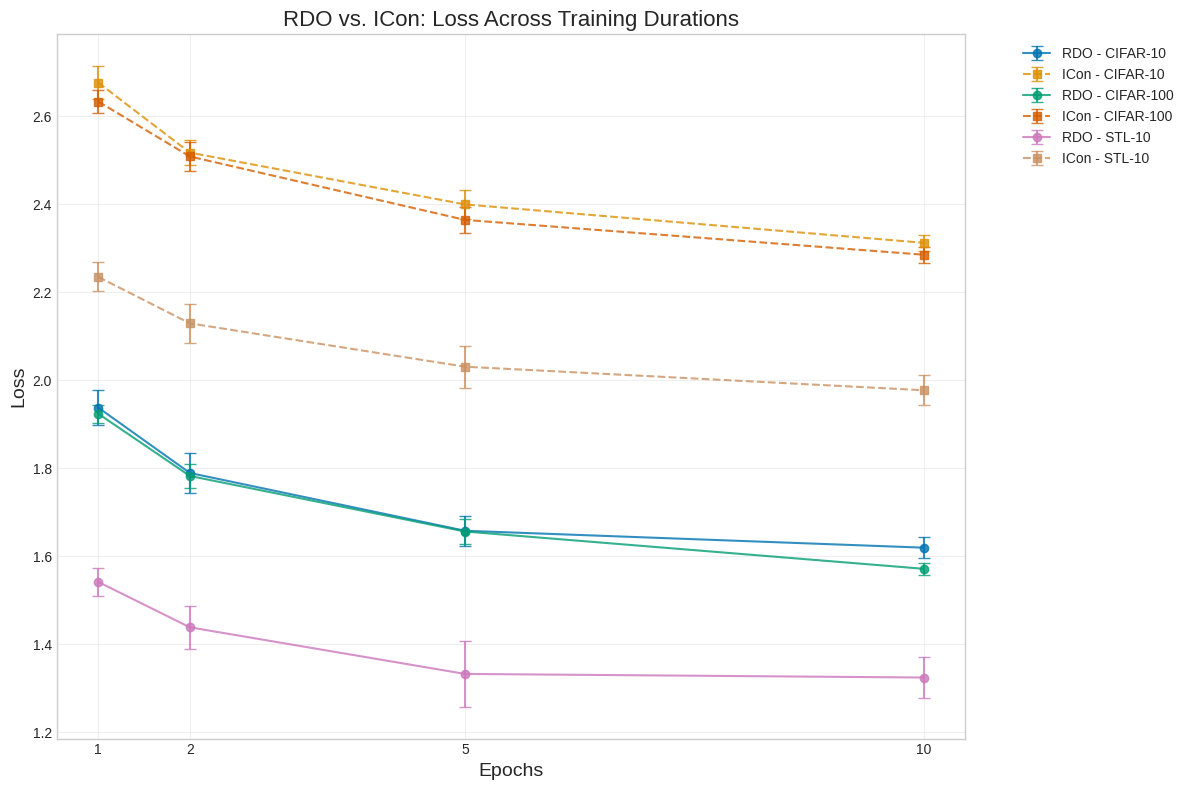

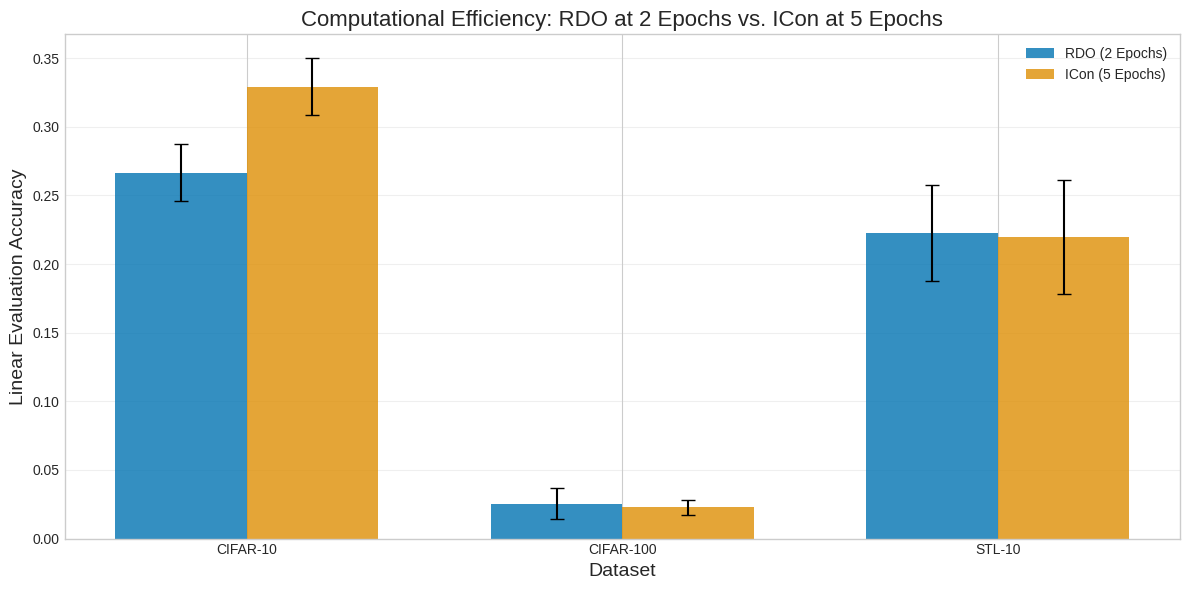

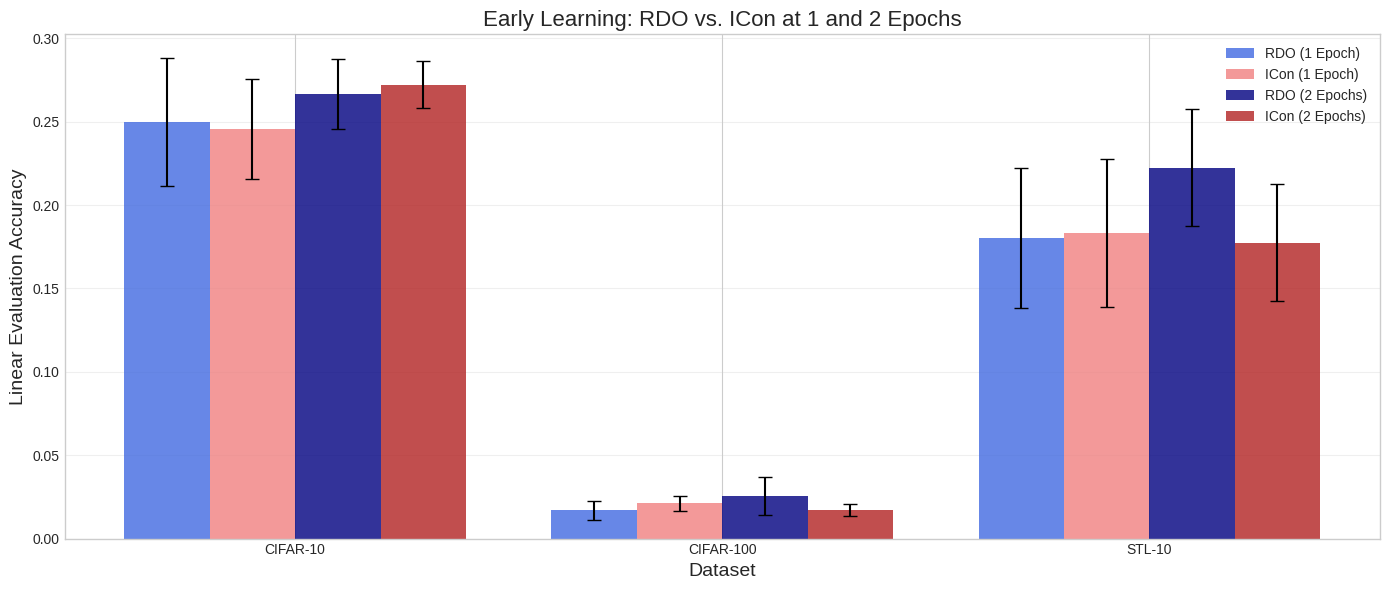

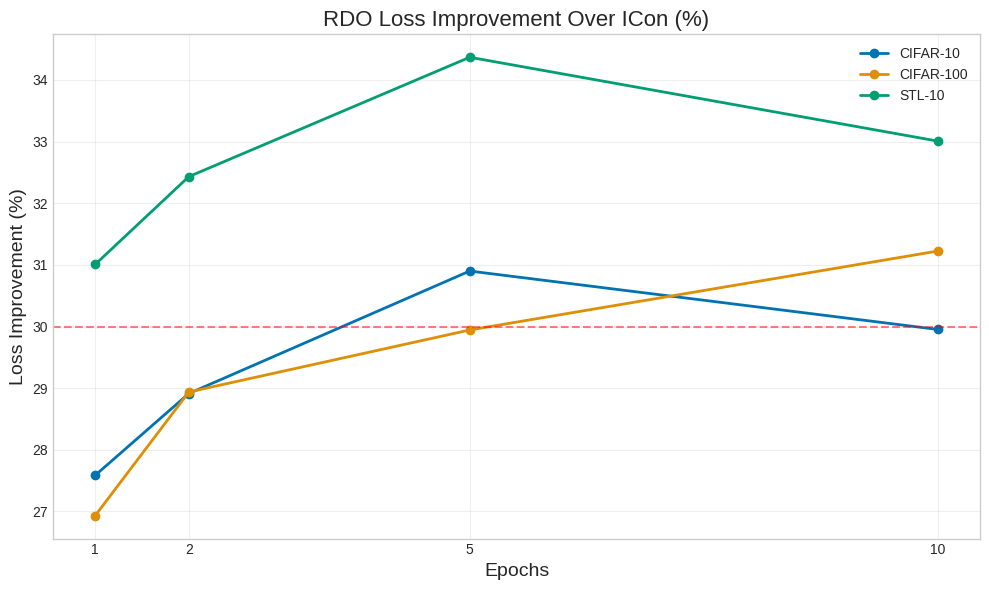

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Setting the style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")

# Define our exact data from experiments
datasets = ['CIFAR-10', 'CIFAR-100', 'STL-10']

# Loss values (mean ± std)
loss_data = {
    'Dataset': np.repeat(datasets, 4),
    'Epochs': np.tile([1, 2, 5, 10], 3),
    'RDO_Loss_Mean': [
        # CIFAR-10
        1.9384, 1.7897, 1.6584, 1.6200,
        # CIFAR-100
        1.9245, 1.7829, 1.6567, 1.5720,
        # STL-10
        1.5422, 1.4390, 1.3331, 1.3249
    ],
    'RDO_Loss_Std': [
        # CIFAR-10
        0.0403, 0.0445, 0.0335, 0.0233,
        # CIFAR-100
        0.0205, 0.0269, 0.0290, 0.0133,
        # STL-10
        0.0310, 0.0483, 0.0742, 0.0460
    ],
    'ICon_Loss_Mean': [
        # CIFAR-10
        2.6768, 2.5176, 2.4000, 2.3127,
        # CIFAR-100
        2.6338, 2.5089, 2.3648, 2.2857,
        # STL-10
        2.2353, 2.1297, 2.0312, 1.9777
    ],
    'ICon_Loss_Std': [
        # CIFAR-10
        0.0369, 0.0291, 0.0321, 0.0184,
        # CIFAR-100
        0.0251, 0.0337, 0.0301, 0.0184,
        # STL-10
        0.0329, 0.0451, 0.0473, 0.0344
    ]
}

# Linear evaluation accuracy (mean ± std)
acc_data = {
    'Dataset': np.repeat(datasets, 4),
    'Epochs': np.tile([1, 2, 5, 10], 3),
    'RDO_Acc_Mean': [
        # CIFAR-10
        0.2496, 0.2667, 0.3078, 0.2894,
        # CIFAR-100
        0.0170, 0.0255, 0.0255, 0.0227,
        # STL-10
        0.1803, 0.2225, 0.2141, 0.2113
    ],
    'RDO_Acc_Std': [
        # CIFAR-10
        0.0384, 0.0208, 0.0374, 0.0299,
        # CIFAR-100
        0.0057, 0.0115, 0.0072, 0.0113,
        # STL-10
        0.0422, 0.0350, 0.0559, 0.0367
    ],
    'ICon_Acc_Mean': [
        # CIFAR-10
        0.2454, 0.2723, 0.3291, 0.3206,
        # CIFAR-100
        0.0213, 0.0170, 0.0227, 0.0199,
        # STL-10
        0.1831, 0.1775, 0.2197, 0.2479
    ],
    'ICon_Acc_Std': [
        # CIFAR-10
        0.0300, 0.0139, 0.0208, 0.0192,
        # CIFAR-100
        0.0045, 0.0035, 0.0053, 0.0053,
        # STL-10
        0.0445, 0.0352, 0.0414, 0.0363
    ]
}

# Convert to pandas DataFrames
loss_df = pd.DataFrame(loss_data)
acc_df = pd.DataFrame(acc_data)

# FIGURE 1: Loss comparison across epochs
plt.figure(figsize=(12, 8))

for dataset in datasets:
    # Filter data for this dataset
    dataset_loss = loss_df[loss_df['Dataset'] == dataset]

    # Plot RDO
    plt.errorbar(dataset_loss['Epochs'], dataset_loss['RDO_Loss_Mean'],
                 yerr=dataset_loss['RDO_Loss_Std'],
                 fmt='o-', label=f'RDO - {dataset}', capsize=4, alpha=0.8)

    # Plot ICon
    plt.errorbar(dataset_loss['Epochs'], dataset_loss['ICon_Loss_Mean'],
                 yerr=dataset_loss['ICon_Loss_Std'],
                 fmt='s--', label=f'ICon - {dataset}', capsize=4, alpha=0.8)

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('RDO vs. ICon: Loss Across Training Durations', fontsize=16)
plt.xticks([1, 2, 5, 10])
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('figure1_loss_comparison.png', dpi=300)
plt.show()

# FIGURE 2: 2 vs 5 epoch comparison (computational efficiency)
plt.figure(figsize=(12, 6))

x = np.arange(len(datasets))
width = 0.35

# Extract 2-epoch RDO and 5-epoch ICon data
rdo_2epoch = acc_df[acc_df['Epochs'] == 2][['Dataset', 'RDO_Acc_Mean', 'RDO_Acc_Std']].sort_values('Dataset')
icon_5epoch = acc_df[acc_df['Epochs'] == 5][['Dataset', 'ICon_Acc_Mean', 'ICon_Acc_Std']].sort_values('Dataset')

rdo_means = rdo_2epoch['RDO_Acc_Mean'].values
rdo_stds = rdo_2epoch['RDO_Acc_Std'].values
icon_means = icon_5epoch['ICon_Acc_Mean'].values
icon_stds = icon_5epoch['ICon_Acc_Std'].values

plt.bar(x - width/2, rdo_means, width, yerr=rdo_stds,
        label='RDO (2 Epochs)', capsize=5, alpha=0.8)
plt.bar(x + width/2, icon_means, width, yerr=icon_stds,
        label='ICon (5 Epochs)', capsize=5, alpha=0.8)

plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Linear Evaluation Accuracy', fontsize=14)
plt.title('Computational Efficiency: RDO at 2 Epochs vs. ICon at 5 Epochs', fontsize=16)
plt.xticks(x, datasets)
plt.grid(True, alpha=0.3, axis='y')
plt.legend()
plt.tight_layout()
plt.savefig('figure2_computational_efficiency.png', dpi=300)
plt.show()

# FIGURE 3: 1 vs 2 epoch comparison (early learning)
plt.figure(figsize=(14, 6))

x = np.arange(len(datasets))
width = 0.2

# Extract data for epochs 1 and 2
rdo_1epoch = acc_df[acc_df['Epochs'] == 1][['Dataset', 'RDO_Acc_Mean', 'RDO_Acc_Std']].sort_values('Dataset')
icon_1epoch = acc_df[acc_df['Epochs'] == 1][['Dataset', 'ICon_Acc_Mean', 'ICon_Acc_Std']].sort_values('Dataset')
rdo_2epoch = acc_df[acc_df['Epochs'] == 2][['Dataset', 'RDO_Acc_Mean', 'RDO_Acc_Std']].sort_values('Dataset')
icon_2epoch = acc_df[acc_df['Epochs'] == 2][['Dataset', 'ICon_Acc_Mean', 'ICon_Acc_Std']].sort_values('Dataset')

plt.bar(x - 3*width/2, rdo_1epoch['RDO_Acc_Mean'].values, width, yerr=rdo_1epoch['RDO_Acc_Std'].values,
        label='RDO (1 Epoch)', capsize=5, alpha=0.8, color='royalblue')
plt.bar(x - width/2, icon_1epoch['ICon_Acc_Mean'].values, width, yerr=icon_1epoch['ICon_Acc_Std'].values,
        label='ICon (1 Epoch)', capsize=5, alpha=0.8, color='lightcoral')
plt.bar(x + width/2, rdo_2epoch['RDO_Acc_Mean'].values, width, yerr=rdo_2epoch['RDO_Acc_Std'].values,
        label='RDO (2 Epochs)', capsize=5, alpha=0.8, color='navy')
plt.bar(x + 3*width/2, icon_2epoch['ICon_Acc_Mean'].values, width, yerr=icon_2epoch['ICon_Acc_Std'].values,
        label='ICon (2 Epochs)', capsize=5, alpha=0.8, color='firebrick')

plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Linear Evaluation Accuracy', fontsize=14)
plt.title('Early Learning: RDO vs. ICon at 1 and 2 Epochs', fontsize=16)
plt.xticks(x, datasets)
plt.grid(True, alpha=0.3, axis='y')
plt.legend()
plt.tight_layout()
plt.savefig('figure3_early_learning.png', dpi=300)
plt.show()

# Compute the improvement percentages for loss reduction
loss_df['Improvement'] = (loss_df['ICon_Loss_Mean'] - loss_df['RDO_Loss_Mean']) / loss_df['ICon_Loss_Mean'] * 100

# Create a bonus figure showing the loss improvement percentage by epochs
plt.figure(figsize=(10, 6))
for dataset in datasets:
    dataset_loss = loss_df[loss_df['Dataset'] == dataset]
    plt.plot(dataset_loss['Epochs'], dataset_loss['Improvement'], 'o-',
             label=dataset, linewidth=2)

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss Improvement (%)', fontsize=14)
plt.title('RDO Loss Improvement Over ICon (%)', fontsize=16)
plt.xticks([1, 2, 5, 10])
plt.grid(True, alpha=0.3)
plt.legend()
plt.axhline(y=30, color='red', linestyle='--', alpha=0.5, label='30% Threshold')
plt.tight_layout()
plt.savefig('bonus_improvement_percentage.png', dpi=300)
plt.show()